## Описание поректа

Необходимо протестировать модель которая сможет с большой вероятностью предсказать закроется ли стартап или нет.

### Описание данных

Описание полей данных

* name - Название стартапа
* category_list - Список категорий, к которым относится стартап
* funding_total_usd - Общая сумма финансирования в USD
* status - Статус стартапа (закрыт или действующий)
* country_code - Код страны
* state_code - Код штата
* region - Регион
* city - Город
* funding_rounds - Количество раундов финансирования
* founded_at - Дата основания
* first_funding_at - Дата первого раунда финансирования
* last_funding_at - Дата последнего раунда финансирования
* closed_at - Дата закрытия стартапа (если применимо)
* lifetime - Время существования стартапа в днях

## Подготовка окружения

### Загрузим модули необходимые для работы

In [199]:
!pip3 install scikit-learn --upgrade
!pip3 install catboost
#!pip3 install missingno
!pip3 install catboost

#import missingno as msno
import shap 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import datetime
import shap 

import matplotlib.gridspec as gridspec

# Разделение данных и подбор гиперпараметров
from sklearn.model_selection import train_test_split  # Деление данных на обучающую и тестовую выборки
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV  # Автоматический подбор гиперпараметров

# Масштабирование и обработка данных
from sklearn.preprocessing import (
    OneHotEncoder,  # Кодирование категориальных признаков методом one-hot
    OrdinalEncoder,  # Кодирование категорий порядковыми номерами
    StandardScaler,  # Нормализация данных
    MinMaxScaler,  # Масштабирование данных в диапазон [0, 1]
    RobustScaler,  # Масштабирование данных устойчиво к выбросам
    LabelEncoder  # Кодирование целевой переменной
)

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия (классификация)
from sklearn.neighbors import KNeighborsClassifier  # Метод ближайших соседей (kNN, классификация)
from sklearn.tree import DecisionTreeClassifier  # Дерево решений (классификация)
from sklearn.svm import SVC  # Метод опорных векторов (SVM, классификация)
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline  # Пайплайн для объединения этапов обработки и обучения
from sklearn.compose import ColumnTransformer  # Применение разных трансформаций к разным столбцам
from sklearn.impute import SimpleImputer  # Заполнение пропусков в данных

from sklearn.metrics import f1_score, roc_auc_score



from catboost import CatBoostClassifier, Pool

In [200]:
def df_short_view(df): #показывает краткую информацию о таблице
    """
    Args
        df        # датафрейм из которого нужно показать данные.
    Returns 

    """
    print('Размер таблицы:', df.shape)
    print()
    print(df.info())
    print()    
    print(df.isna().sum())
    display(df.head(5))
    return

def camel_to_snake(str, sep=' '):
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += sep + i.lower()
        else:
            snake_register += i
    print(snake_register.lstrip(sep))

def f_string_cuter(str, delimiter):
    """
    #  получает строку и разделитель. 
    Возвращает подстроку до первого разделителя. Если разделитель не втречается - возвращается исходная строка целиком.
    Args
        str            # строка которую проверяем.
        delimiter      # разделитель
    Returns 
        result_string             # результирующая строка
    """
    index = 0

    index = str.find(delimiter)  #  Находит на каком месте впервые встречается delimiter
    if index <0  :
        result_string = str
    else:
        result_string = str[0 : (index )]
    return result_string


def hist_and_box_with_stats(df, column, title, bins,):
    """
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    bins   - количество бинов для гистограммы
    """
    # Вычислим основные статистики
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]
    
    # Создадим сетку графиков: 1 строка и 2 столбца
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f"{title}", fontsize=18)
    
    # Гистограмма с KDE
    sns.histplot(df[column], bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    # Линии для среднего, медианы и моды
    ax[0].axvline(mean, color='green', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].axvline(mode, color='blue', linestyle='-', label=f'Мода = {mode:.2f}')
    ax[0].legend()

    # Диаграмма размаха (boxplot)
    sns.boxplot(x=df[column], ax=ax[1])
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[1].grid(True)
    ax[1].legend()

    # Подгоним графики
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def bar_and_pie(df, column,title):
    """
    График категорийных признаков 
    ------------------------------------
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    xl     - 
    """    
    yl = 'Частота'
    fg = plt.figure(figsize=(16, 8), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
    plt.suptitle(title, fontsize=18)
#
    fig_ax_1 = fg.add_subplot(gs[0, 0])
    df.groupby(column)[column].count().sort_values(ascending = False).plot(kind='bar')
    plt.xlabel(column,  fontsize=18)
    plt.ylabel(yl)
#    plt.title(title)
#    
    fig_ax_2 = fg.add_subplot(gs[0, 1])
    df.groupby(column)[column].count().plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(column,  fontsize=18)
    plt.ylabel(yl)
#    plt.title(title)

In [201]:
def corr_heatmap(df: pd.DataFrame,xl,yh, metod_cor, drop_columns):
        """
        Args ",
            df: pd.DataFrame
            xl: длина графика
            yh: высота графика
            metod_cor:  Method of correlation
                        pearson : standard correlation coefficient
                        kendall : Kendall Tau correlation coefficient
                        spearman : Spearman rank correlation
            drop_columns: колонки которые не попадут на график кореляции
        """ 
        try:
            df = df.drop(columns = drop_columns)
        except:
            df = df
        try:
            df=df.corr(method = metod_cor, numeric_only=True)
        except:
            df=df.corr(method = metod_cor)
        plt.figure(
            figsize=(xl,yh),
    #        dpi= 80\n",
        )
        if metod_cor == 'spearman': 
            plt.title('Матрица корреляции (Спирмен)', fontsize=14)
        if metod_cor == 'pearson': 
            plt.title('Матрица корреляции (Пирсен)', fontsize=14)
        if metod_cor == 'kendall': 
            plt.title('Матрица корреляции (Кенделл)', fontsize=14)
        sns.heatmap(
    #        df.corr(),
     #cmap='coolwarm' ('bwr', 'seismic'),
            df,
            xticklabels=df.columns,
            yticklabels=df.columns, 
            cmap='RdYlGn',
#            cmap='coolwarm' ,#('bwr', 'seismic'),
            center=0,
            annot=True,
    #        robust=True,
        )
        return

def f_lifetime_to_year(date, lifetime):
    """
    #  получает дату и сдвиг. 
    Возвращает подстроку до первого разделителя. Если разделитель не втречается - возвращается исходная строка целиком.
    Args
        str            # строка которую проверяем.
        delimiter      # разделитель
    Returns 
        result_year             # результирующий год
    """
    aDate = datetime.date.fromisoformat(date)

    aDate =  aDate - pd.DateOffset(days= lifetime) 
    result_year = aDate.year

    return result_year

## Загрузка данных

In [202]:
ds_sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
ds_test = pd.read_csv('kaggle_startups_test_28062024.csv')
ds_train = pd.read_csv('kaggle_startups_train_28062024.csv')

In [203]:
## Сделаем копию первоначальных данных
ds_sample_bk = ds_sample.copy()
ds_test_bk = ds_test.copy()
ds_train_bk = ds_train.copy()

In [204]:
def f_strip_df (df) :
    df_obj = df.select_dtypes('object')
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df

In [205]:
# удаляем пробелы из начала и конца значенийю

ds_sample = f_strip_df(ds_sample)
ds_test = f_strip_df(ds_test)
ds_train = f_strip_df(ds_train)


### Посмотрим на данные

In [206]:
df_short_view(ds_sample)

Размер таблицы: (13125, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
None

name      0
status    0
dtype: int64


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [207]:
df_short_view(ds_test)

Размер таблицы: (13125, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB
None

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city          

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [208]:
df_short_view(ds_train)

Размер таблицы: (52516, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None

name                     1
category_list         2465
funding_total_usd  

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


### Приведём данные к соответствующему формату

Начнём с ds_sample.

In [209]:
display(ds_sample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


None

Текстовый формат, всё нормально. Не трогаем.

Посмотрим загрузку ds_test

In [210]:
display(ds_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

Видим что **funding_total_usd**, **funding_rounds** и **lifetime** уже в числовом формате.
Преобразуем столбцы **last_funding_at** и **first_funding_at** в datetime64.

In [211]:
ds_test['first_funding_at'] = pd.to_datetime(ds_test['first_funding_at'])
ds_test['last_funding_at'] = pd.to_datetime(ds_test['last_funding_at'])

In [212]:
# проверяем результат
display(ds_test.info())
display(ds_test.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


Посмотрим загрузку ds_train

In [213]:
df_short_view(ds_train)

Размер таблицы: (52516, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None

name                     1
category_list         2465
funding_total_usd  

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


Преобразуем столбцы founded_at, last_funding_at, closed_at и first_funding_at в datetime64.

In [214]:
ds_train['first_funding_at'] = pd.to_datetime(ds_train['first_funding_at'])
ds_train['last_funding_at'] = pd.to_datetime(ds_train['last_funding_at'])
ds_train['founded_at'] = pd.to_datetime(ds_train['founded_at'])
ds_train['closed_at'] = pd.to_datetime(ds_train['closed_at'])

In [215]:
display(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

Итог по загрузке данных.
* Изменён формат хранения дат.
* Данные всех 3х наборов данных загруженны в полном объёме. 
* Видно что наботы данных ds_train и ds_test отличаются по набору полей. 

## Проверка данных

Проверка данных включает выявление:
* дубликатов, противоречий, ошибок;
* аномальных наблюдений;
* пропусков.

###  Поиск дубликатов

#### Поиск дубликатов в ds_sample

В наборе два признака name и status . Все 13125 строк заполнены. Проверим категорийный признак на возможные значения.

In [216]:
ds_sample['status'].value_counts()

status
operating    6635
closed       6490
Name: count, dtype: int64

In [217]:
print('Число явных дублей в ds_sample равно', ds_sample.duplicated().sum())

Число явных дублей в ds_sample равно 0


Всего 2 значения. Всё нормально.

#### Поиск дубликатов в ds_train

In [218]:
display(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

Большая часть строк заполнены полностью. Дата закрытия указана у 9% стартапов.
Столбец *name* заполнен полностью. Проверим его на дубли.

In [219]:
print('Число явных дублей в ds_test равно', ds_train.duplicated().sum())
print('Число явных дублей в ds_test[name]  равно', ds_train['name'].duplicated().sum())

Число явных дублей в ds_test равно 0
Число явных дублей в ds_test[name]  равно 0


Полных дублей в наборе данных нет. Дубли в признаке *name* также отсутствуют.

In [220]:
display(ds_train.describe())

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,4.244700e+04,52516.000000,52516,52516,52516,4917
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00
std,1.871173e+08,1.374522,NaN,NaN,NaN,NaN


Видим что после 2015-12-05 нет раундов финансирования.  Скорее всего в выгрузке указаны компании созданные до 2016 года, и отслеживается их судьба до 2018 года.
В столбце привлечённых средств , в максимуме указано 30 миллиардов долларов. Незнаю насколько это правдоподобно. Пока оставляем.

Итог проверки данных


#### Поиск дубликатов в ds_test

In [221]:
display(ds_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

In [222]:
print('Число явных дублей в ds_test равно', ds_test.duplicated().sum())
print('Число явных дублей в ds_test[name]  равно', ds_test['name'].duplicated().sum())

Число явных дублей в ds_test равно 0
Число явных дублей в ds_test[name]  равно 0


In [223]:
display(ds_test.describe())

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,1.054700e+04,13125.000000,13125,13125,13125.000000
mean,1.654910e+07,1.714438,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,3097.609524
min,1.000000e+00,1.000000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000000
25%,3.200000e+05,1.000000,2009-11-16 00:00:00,2011-01-10 00:00:00,1726.000000
50%,2.000000e+06,1.000000,2012-08-01 00:00:00,2013-08-21 00:00:00,2526.000000
75%,1.000000e+07,2.000000,2014-04-01 00:00:00,2014-11-11 00:00:00,3866.000000
max,4.715000e+09,15.000000,2015-12-03 00:00:00,2015-12-12 00:00:00,17167.000000
std,9.217283e+07,1.318800,NaN,NaN,2128.356554


Видим что после 2015-12-03 нет раундов финансирования.  Скорее всего в выгрузке указаны компании созданные до 2016 года, и отслеживается их судьба до 2018 года.

В столбце привлечённых средств , в максимуме указано 4.7 миллиардов долларов. Незнаю насколько это правдоподобно. Пока оставляем.
lifetime имеет диапазон от 52 дней до 47 лет. 47 лет - это уже не совсем стартап. Пока оставляем.


### Немного графиков


####  Графики для ds_sample

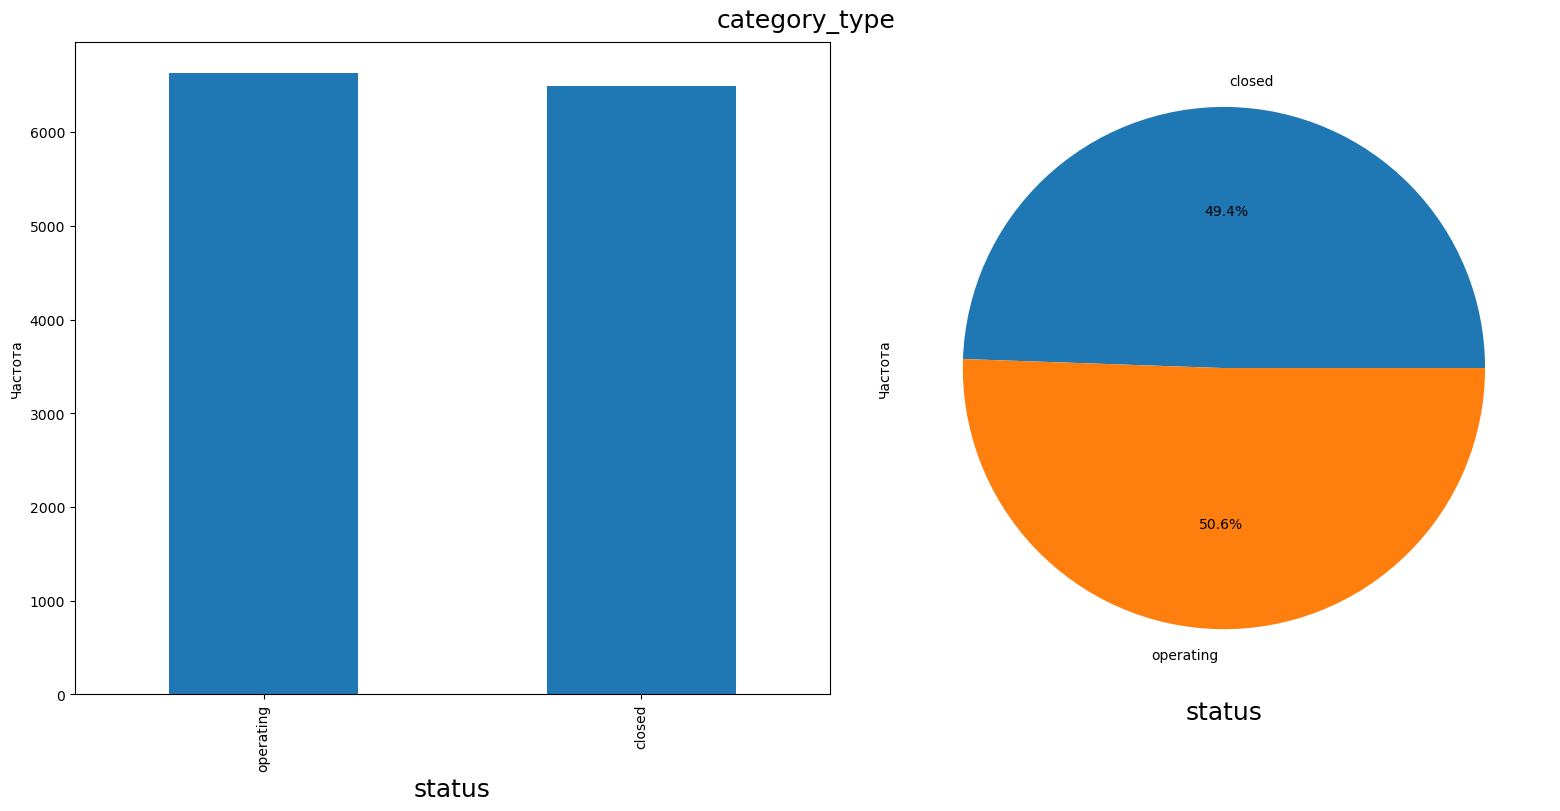

In [224]:
bar_and_pie(ds_sample, 'status','category_type')

Видно что значения на примере распределены равномерно.

####  Графики для ds_train

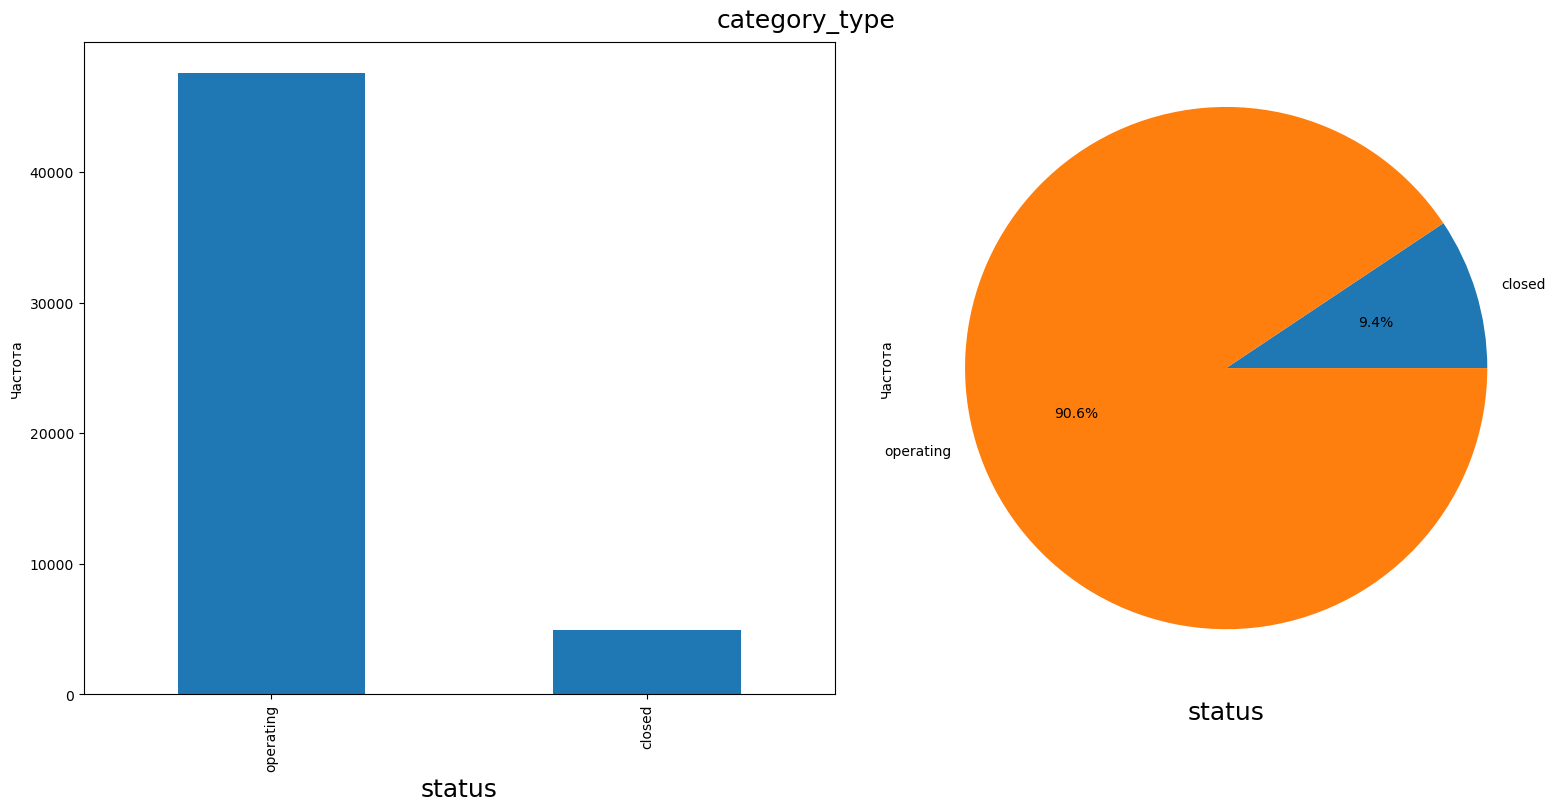

In [225]:
bar_and_pie(ds_train, 'status','category_type')


На тренеровочных данных перекос по статусам значительный: 10 к 1.

In [226]:
def hist_2_sets(df,column_for_paining, column_for_filtering, filter_1, filter_2, set1_label, set2_label ):    
    """
    Строит гистограмму по одному из признаков. Фильтрация происходит по другому БИНАРНОМУ признаку. 
    
    Args
        df                   # Набор данных
        column_for_paining   # По какому признаку строим график
        column_for_filtering # По какому признаку разделяем по цветам
        filter_1             # Условие отбора для первого нобора
        filter_2             # Условие отбора для второго набора
        set1_label           # Название первого набора
        set2_label           # Название второго набора
    Returns 
    """
    set1 = df[column_for_paining].loc[df[column_for_filtering] == filter_1]
    set2 = df[column_for_paining].loc[df[column_for_filtering] == filter_2]
    bins = 30
    plt.figure(figsize=(14, 7), constrained_layout=True)
    plt.hist([set1, set2], bins, label=[set1_label, set2_label])
    plt.legend(loc='upper right')
    plt.title(column_for_paining)
    plt.ylabel('Частота')
    plt.xlabel(column_for_paining)
    plt.show()
    return

In [227]:
def f_df_filtering(df, column, count):
    """
    Фильтрует набор данных по определённому столбцу. количество ТОП передаётся как параметр
    
    """
    df_filtered = []
    filter_list = df[column].value_counts().to_frame().head(count)
    df_filtered = df.loc[df[column].isin(filter_list.index)]
    return df_filtered
    

In [228]:
df_filtered = f_df_filtering(ds_train, 'country_code', 15)


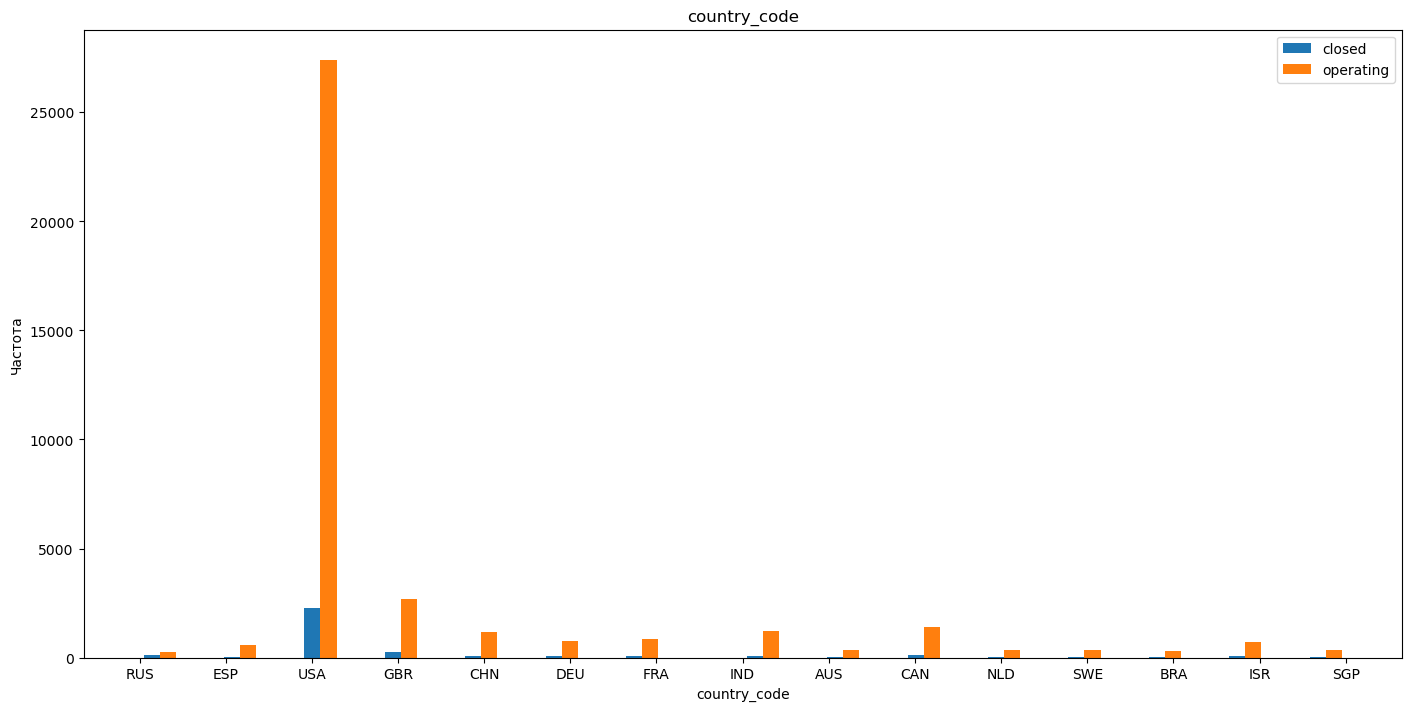

In [229]:


hist_2_sets(df_filtered,      #                         # Набор данных
            'country_code',   #  column_for_paining     # По какому признаку строим график
            'status',            #  column_for_filtering   # По какому признаку разделяем по цветам
            'closed',                #  filter_1               # Условие отбора для первого нобора
            'operating',                 #  filter_2               # Условие отбора для второго набора
            'closed',         #  set1_label             # Название первого набора
            'operating',           #  set2_label             # Название второго набора
           )    

Видно что количество действующих компаний  на порядок превышает количество закрытых. В топ списке стран представлены в основном США и европейские страны. 
Плюс Индия, Бразилия, Израиль, Сингапур и Россия.

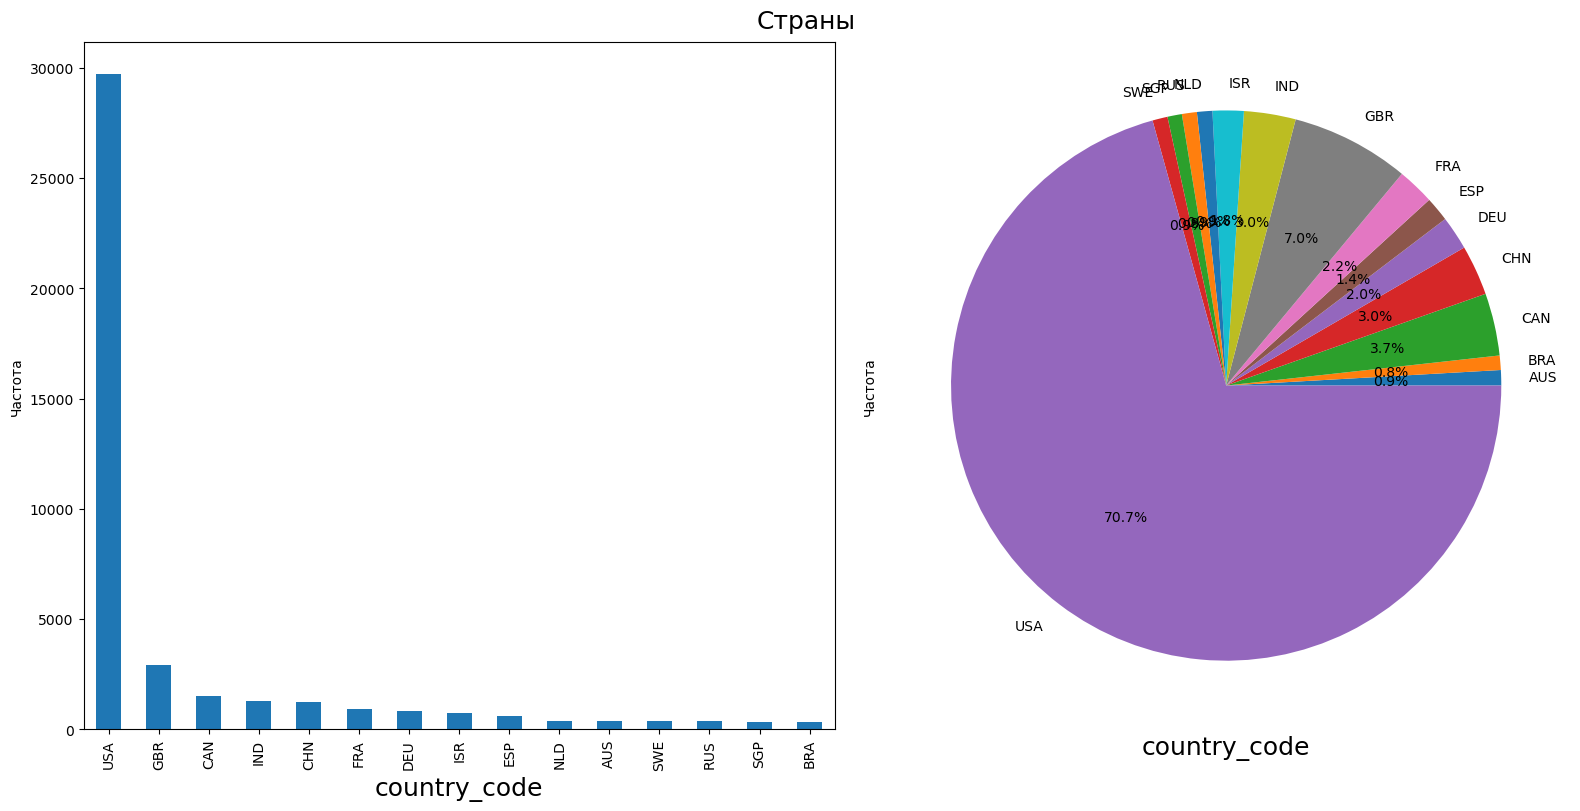

In [230]:
bar_and_pie(df_filtered, 'country_code','Страны')

Видно что в ТОП15 стартапы из США занимают 70% .Компании из Великобритании занимают 7%

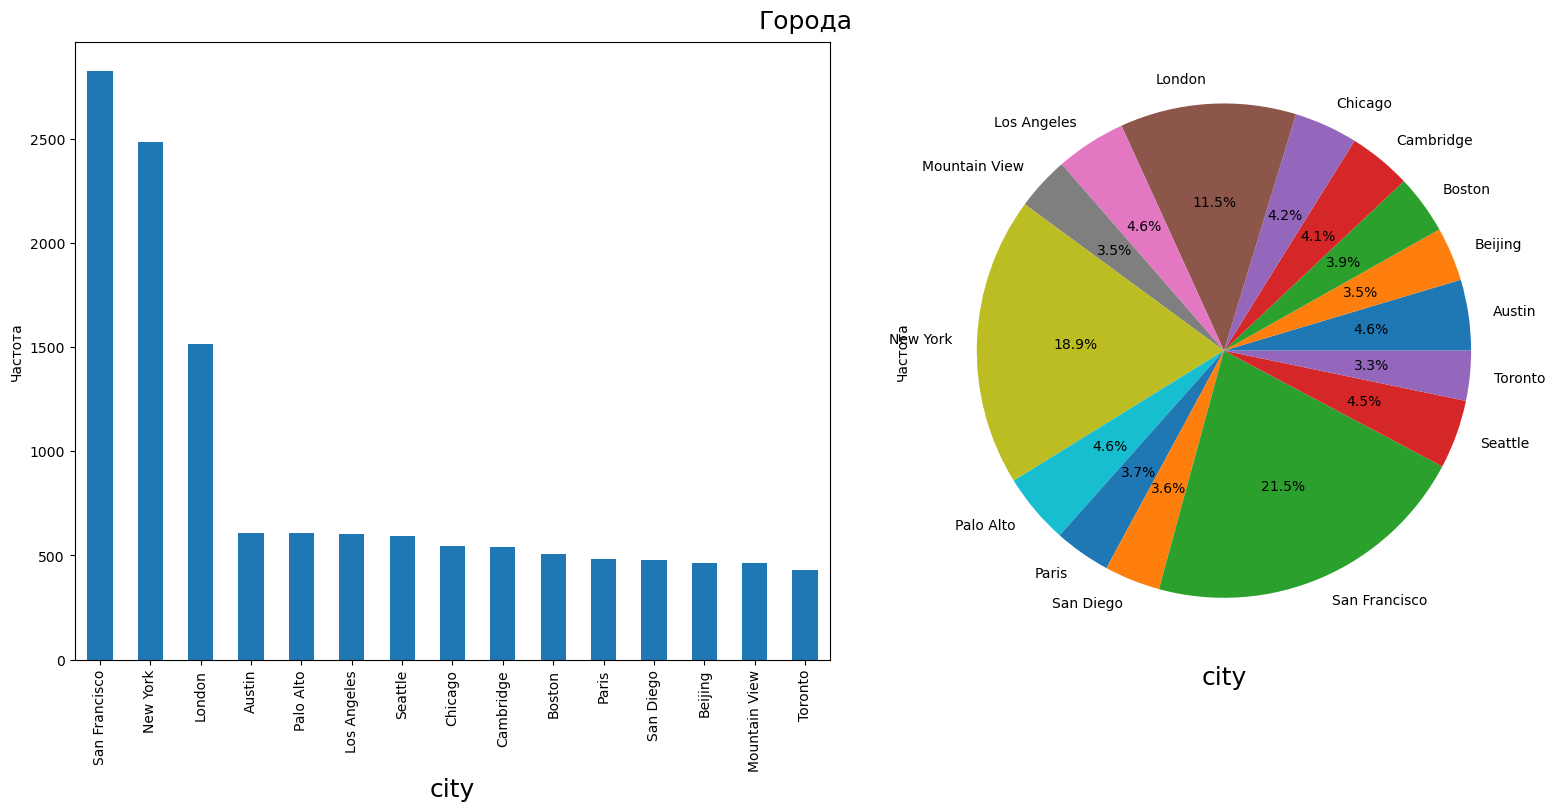

In [231]:
df_filtered = f_df_filtering(ds_train, 'city', 15)
bar_and_pie(df_filtered, 'city','Города')

С большим отрывом лидирует Сан-Франциско. 47% среди ТОП 15 городов.

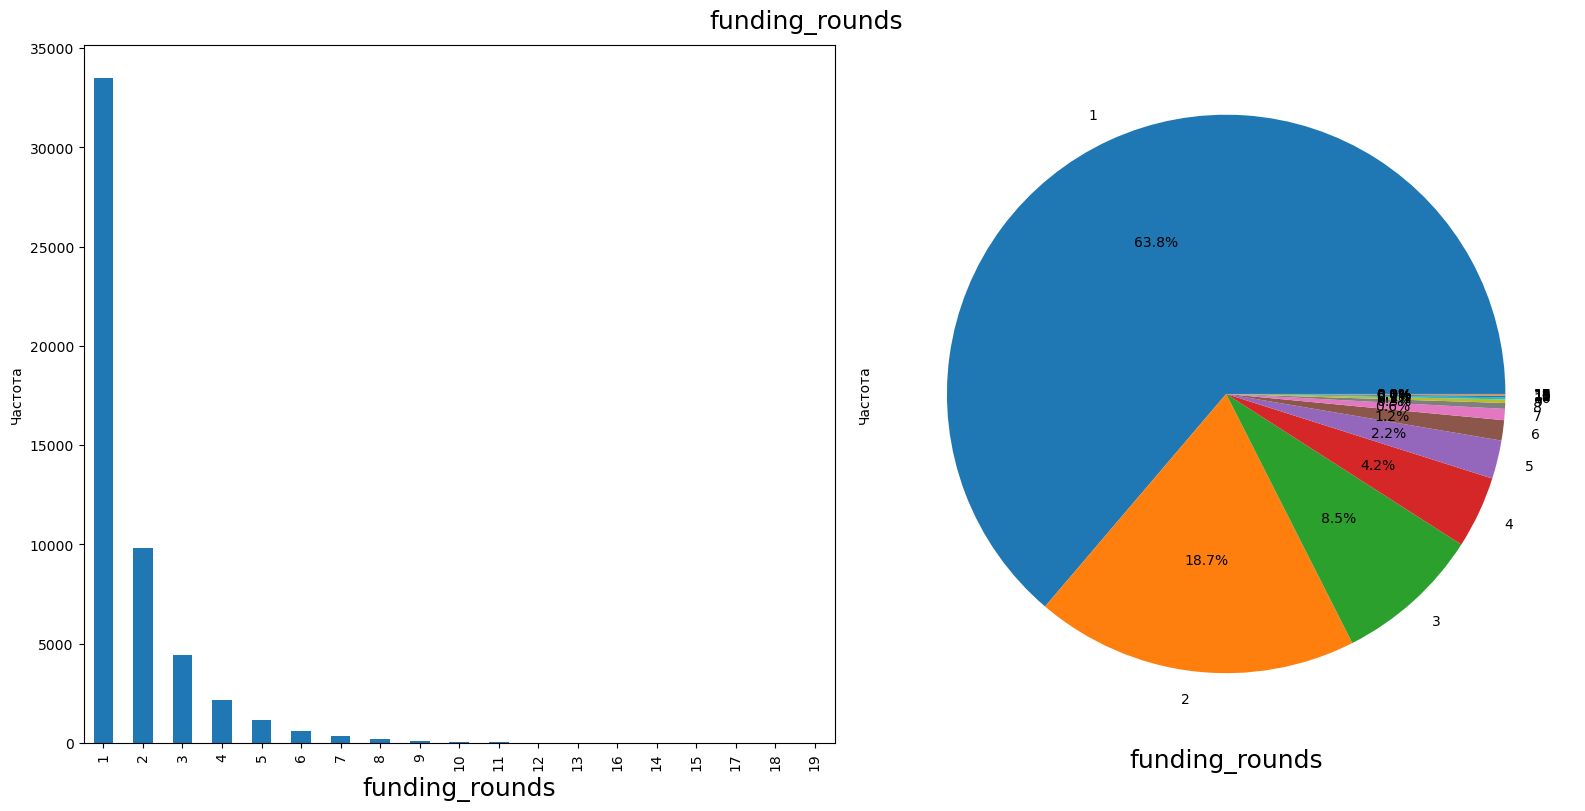

In [232]:
bar_and_pie(ds_train, 'funding_rounds','funding_rounds')

63.8% компаний дошли только до первого раунда финансирования. 7 раундов и более име.т менее 1% сратрапов. 

In [233]:
def hist_with_stats(df, column, title, bins,):
    """
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    bins   - количество бинов для гистограммы
    """

    df=df.loc[df[column].notnull()]
    
    # Вычислим основные статистики
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]
    
#    display(mean)
#    display(median)
#    display(mode)    
    
    
    # Гистограмма с KDE
    sns.histplot(df[column], bins=bins, kde=True,)
    plt.title('Гистограмма', fontsize=10)
#    plt.set_xlabel(column)
    plt.ylabel('Частота')
    plt.grid(True)
    
    # Линии для среднего, медианы и моды
    plt.axvline(mean, color='green', linestyle='--', label=f'Среднее = {mean:.2f}')
    plt.axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    plt.axvline(mode, color='blue', linestyle='-', label=f'Мода = {mode:.2f}')
    plt.legend()

    # Подгоним графики
#    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

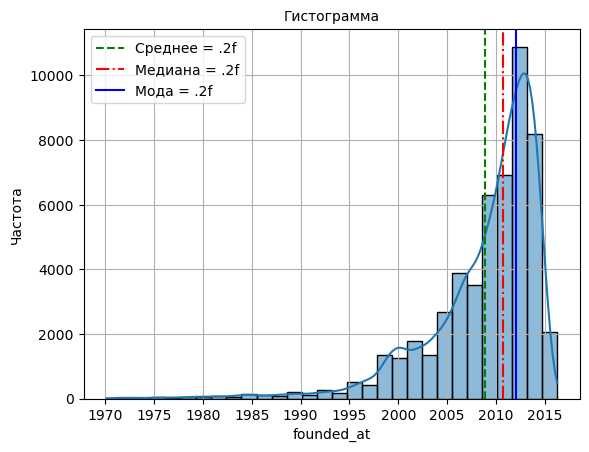

In [234]:
hist_with_stats(ds_train, 'founded_at','Количество компаний открытых по годам', 30)


Видим медиану в 2010-10-01 и моду в 2012-01-01

In [235]:
#sns.histplot(ds_train['founded_at'], bins=10, kde=True,)

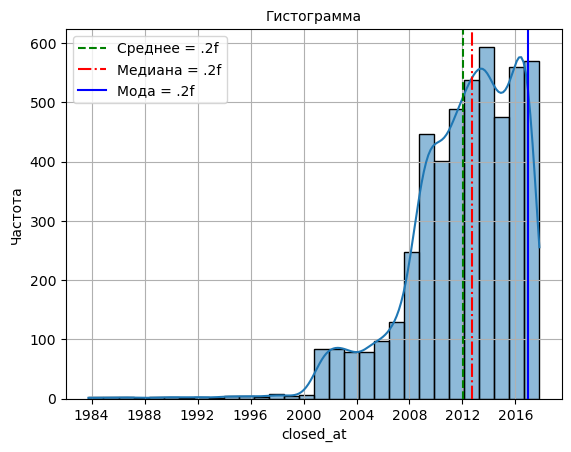

In [236]:
hist_with_stats(ds_train, 'closed_at','Количество компаний закрытых по годам', 30)

Видно что после бума оснований компаний в 2010-2012 годах, с 2012 года наблюдается закрытие компаний. Но закрытых компаний всё равно в несколько раз меньше чем открытых.

#### Графики для ds_test

In [237]:
#bar_and_pie(ds_test, 'status','category_type')

## Очистка данных

Очистка данных включает в себя.
* устранение дубликатов, противоречий и ошибок;
* обработку аномальных наблюдений;
* обработку пропусков.

### Устранение дубликатов

дубликатов нет ни к одном из наборов данных.

### Обработка пропусков

#### Обработаем пропуски в ds_test

In [238]:
display(ds_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

In [239]:
ds_test['funding_total_usd'] = ds_test['funding_total_usd'].fillna(0)
ds_test['funding_rounds'] = ds_test['funding_rounds'].fillna(0)

Заполним пустоты в **category_list**

In [240]:
ds_test['category_list'] = ds_test['category_list'].fillna('Other')

Заполним пустоты в country_code

In [241]:
ds_test['country_code'].value_counts().head(5)

country_code
USA    7428
GBR     725
CAN     369
IND     307
CHN     301
Name: count, dtype: int64

С большим отрывом лидируют США. На них приходится более половины записей. Заполним пустоты в признаке **country_code** записав туда самое популярное значение.

In [242]:
ds_test['country_code'] = ds_test['country_code'].fillna('USA')

Заполним пустоты в state_code

In [243]:
ds_test['state_code'].value_counts().head(5)

state_code
CA    2552
NY     789
MA     487
TX     410
H9     382
Name: count, dtype: int64

CA - хороший выбор. 

In [244]:
ds_test['state_code'] = ds_test['state_code'].fillna('CA')

In [245]:
ds_test['region'].value_counts().head(5)

region
SF Bay Area      1750
New York City     712
London            481
Boston            460
Los Angeles       343
Name: count, dtype: int64

Заполним пустоту в регионах 

In [246]:
ds_test['region'] = ds_test['region'].fillna('SF Bay Area')

Посмотрим самые популярные города.

In [247]:
ds_test['city'].value_counts().head(5)

city
San Francisco    656
New York         641
London           384
Austin           159
Palo Alto        155
Name: count, dtype: int64

В качестве города укажем самый популярный горов в Калифорнии - San Francisco

In [248]:
ds_test['city'] = ds_test['city'].fillna('San Francisco')

Проверяем результат. Ожидаем что пустых значений не останется.

In [249]:
## Проверяем
display(ds_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

In [250]:
#ds_test_prep['category_type'].value_counts(ascending=False).head(30)
ds_test['category_list'].value_counts(ascending=False).head(30)
#df_short_view(ds_train)

category_list
Software               775
Biotechnology          693
Other                  591
E-Commerce             263
Mobile                 255
Clean Technology       234
Curated Web            191
Hardware + Software    181
Games                  180
Health Care            176
Enterprise Software    169
Manufacturing          157
Health and Wellness    148
Advertising            141
Finance                106
Education              101
Semiconductors          96
Security                87
Consulting              87
Real Estate             83
Web Hosting             80
Social Media            79
Hospitality             75
Analytics               69
Fashion                 62
Medical                 57
Technology              52
Internet                47
Travel                  45
Entertainment|Games     41
Name: count, dtype: int64

Пропуски в данных **ds_test** устранены, двигаемся дальше.

In [251]:
display(ds_test.info())
display(ds_test.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,USA,CA,SF Bay Area,San Francisco,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,USA,CA,SF Bay Area,San Francisco,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


In [252]:
ds_test.iloc[[0, 1, 2, 3]].isna()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False


In [253]:
ds_train.iloc[[0, 1, 2, 3]].isna()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,True,True,True,True,False,False,False,False,True


#### Обработаем пропуски в ds_train

In [254]:
display(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

Заполним 0 пропуски в **funding_total_usd** и **funding_rounds**. Если там пусто - значит ничего нет. 

In [255]:
ds_train['funding_total_usd'] = ds_train['funding_total_usd'].fillna(0)
ds_train['funding_rounds'] = ds_train['funding_rounds'].fillna(0)

Заполним пустоты в **category_list**

In [256]:
ds_train['category_list'] = ds_train['category_list'].fillna('Other')

Повторим заполнение  country_code, state_code , region и city как делалось в **ds_test**

In [257]:
ds_train['country_code'].value_counts().head(5)

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
Name: count, dtype: int64

С большим отрывом лидируют США. На них приходится более половины записей. Заполним пустоты в признаке **country_code** записав туда самое популярное значение.

In [258]:
ds_train['country_code'] = ds_train['country_code'].fillna('USA')

Заполним пустоты в state_code

In [259]:
ds_train['state_code'].value_counts().head(5)

state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
Name: count, dtype: int64

In [260]:
ds_train['state_code'] = ds_train['state_code'].fillna('CA')

In [261]:
ds_train['region'] = ds_train['region'].fillna('SF Bay Area')

In [262]:
ds_train['city'] = ds_train['city'].fillna('San Francisco')

In [263]:
display(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

Из 52516 строк признак name заполнен у 52515. Заполним значением.

In [264]:
ds_train['name'] = ds_train['name'].fillna('1234567')

#### Проверяем результат после очистки данных

In [265]:

display(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

In [266]:
display(ds_train.head(10))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaT
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaT
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaT
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaT
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaT


In [267]:
display(ds_test.info())
display(ds_test.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,0.000000e+00,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,1.600000e+05,USA,CA,SF Bay Area,San Francisco,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,2.684200e+07,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4.000000e+06,USA,CA,SF Bay Area,San Francisco,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8.710000e+06,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,1.320000e+04,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


## Трансформация данных

In [268]:
#ds_test['category_list'].value_counts(ascending=False).head(30)


## Дополнение данных 

Необходимо сделать так чтобы в наборах данных ds_train и ds_test были одинаковый набор исходных признаков.


In [269]:
ds_sample_prep = ds_sample.copy()
ds_train_prep = ds_train.copy()
ds_test_prep = ds_test.copy()

In [270]:
#ds_test_prep.info()

In [271]:
display('ds_train_prep')
display(ds_train_prep.columns) 
display('')
display('ds_test_prep')
display(ds_test_prep.columns)

s1 = ds_train_prep.columns.tolist()
s2 = ds_test_prep.columns.tolist()

result = list(set(s1) ^ set(s2))
display('Различие в столбцах')
display(result)

'ds_train_prep'

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

''

'ds_test_prep'

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')

'Различие в столбцах'

['founded_at', 'closed_at', 'status', 'lifetime']

### Начнём с ds_train_prep

Отсутствует признак lifetime. Рассчитаем его.


In [272]:
ds_train_prep["lifetime"] = 0
# Для действующих стартапов записывает разницу между датой создания и датой среза ('2018-01-01')
ds_train_prep["lifetime"].loc[ds_train_prep["closed_at"].isna()] = (pd.to_datetime('2018-01-01')  - ds_train_prep['founded_at']).dt.days 

# Для закрытых стартапов записывает разницу между датой создания и датой закрытия "closed_at"
ds_train_prep["lifetime"].loc[~ds_train_prep["closed_at"].isna()]  = (ds_train_prep['closed_at'] - ds_train_prep['founded_at']).dt.days 


In [273]:
#ds_train_prep["lifetime"].describe()
#ds_test_prep.info()
#ds_train_prep.info()
display(ds_train_prep.head(20))


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,4383
3,Sancilio and Company,Health Care,2.225000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,2011-09-01,2014-07-18,NaT,5114
4,WireTough Cylinders,Manufacturing,0.000000e+00,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2791
5,Connected Sports Ventures,Mobile,4.300000e+06,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaT,2452
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,9.000000e+07,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaT,6575
7,Mesh Networks,Software,4.300000e+06,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaT,4748
8,AngioScore,Biotechnology,4.200000e+07,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaT,5479
9,Vidatronic,Semiconductors,1.250500e+06,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaT,2922


In [274]:

display(ds_train_prep.loc[ds_train_prep['status'] != 'operating'].head(10))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
12,Iberic Premium,Other,107239.0,closed,USA,CA,SF Bay Area,San Francisco,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10,714
16,Salesjob,Other,0.0,closed,USA,CA,SF Bay Area,San Francisco,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11,952
23,Vputi,Consumers,50000.0,closed,RUS,91,RUS - Other,Krasnoyarsk,1,2012-04-26,2013-03-08,2013-03-08,2014-09-04,861
24,Savasti,Other,0.0,closed,USA,CA,SF Bay Area,San Francisco,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03,672
29,NewWorld Communications,Technology,150000000.0,closed,USA,CA,SF Bay Area,San Francisco,1,1999-05-04,2000-06-01,2000-06-01,2001-12-28,969
53,Domosite,Home Owners|Internet|Private Social Networking,700000.0,closed,USA,CA,SF Bay Area,San Francisco,1,2011-07-12,2012-10-01,2012-10-01,2014-04-26,1019
78,Efficient Photon,Other,0.0,closed,USA,CA,SF Bay Area,San Francisco,1,2010-02-12,2011-09-22,2011-09-22,2013-08-07,1272
83,efectivox,Finance|Services|Transportation,6192900.0,closed,ESP,29,Leganes,Leganés,1,2010-07-01,2011-02-26,2011-02-26,2012-02-26,605
93,NMotive Research,Eyewear|Technology|Tracking,15079.0,closed,USA,CA,SF Bay Area,San Francisco,1,2012-01-01,2013-01-01,2013-01-01,2014-06-09,890
96,"Heartscape Technologies, Inc.",Healthcare Services|Medical Devices|Technology,18400000.0,closed,USA,NY,New York City,New York,2,2005-11-01,2005-10-10,2007-04-25,2008-12-22,1147


In [275]:
display (ds_train_prep.head(5))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,4383
3,Sancilio and Company,Health Care,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,2011-09-01,2014-07-18,NaT,5114
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2791


In [276]:
ds_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


(array([2681.,  204.,  276.,  113.,  209.,  177.,   90.,   60.,   48.,
         220.]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000.]),
 <BarContainer object of 10 artists>)

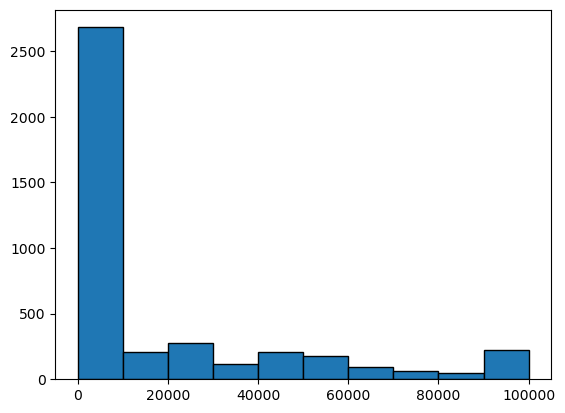

In [277]:
ds_test_prep['funding_total_usd']

plt.hist(ds_test_prep['funding_total_usd'], bins=10, edgecolor='black', range=(0, 100000))

### Переходим к ds_test_prep

In [278]:
#founded_at

In [279]:
ds_test_prep['founded_at'] =  ds_test_prep['lifetime'].apply(lambda x: pd.to_datetime('2018-01-01') - pd.Timedelta(days=x))
#pd.to_datetime('2018-01-01') - pd.Timedelta(days=ds_test_prep['lifetime'])

#new_date = date - pd.Timedelta(days=days_to_subtract)

In [280]:
display(ds_test_prep)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,founded_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,3501,2008-06-01
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2010-07-25
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2014-06-16
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,2005-01-01
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,2001-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,2011-10-18
13121,GlobaTrek,Software,0.0,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,2012-01-01
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,2010-01-01
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,2014-03-17


In [281]:
display('ds_train_prep')
display(ds_train_prep.columns) 
display('')
display('ds_test_prep')
display(ds_test_prep.columns)

s1 = ds_train_prep.columns.tolist()
s2 = ds_test_prep.columns.tolist()

#s1.compare(s2)

result = list(set(s1) ^ set(s2))
display('Различие в столбцах')
display(result)

'ds_train_prep'

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime'],
      dtype='object')

''

'ds_test_prep'

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime', 'founded_at'],
      dtype='object')

'Различие в столбцах'

['closed_at', 'status']

Признак **status** мы предсказываем, а признак **closed_at** явно на него указывает. Остальные признаки совпадают.


Итог шага Дополнения данных:
* в наборе данных **ds_test_prep** добавлены признаки **founded_at**
* в наборе данных добавлен признак **ds_train_prep**


### Создадим дополнительные признаки

Т.к. с полной датой работать тяжело, добавим дополнительно признаки содержащие:
* год основания компании
* год первого раунда финансирования
* год последнего раунда финансирования компании
* год закрытия ? Этот признак есть тольуо у закрытых компаний. Его не будем заводить.
* Количество месяцев между появлением стартапа и первым раундом финансирования.

#### Создадим дополнительные признаки у ds_train_prep

Разделим признак **funding_total_usd** на сегменты с осечками 0, 1000, 10K, 100K, 1M, 10M, 100M, 100M+.

Назовём их: 'Zero', '1k', '10k', '1M','10M', '100M', '100M_plus'

In [282]:

def f_usd_segment(df):
    bins = [0,0.99, 1000, 10000, 100000, 1000000, 10000000,1000000000, 100000000000]
    labels = ['Zero', '1k', '10k', '100k', '1M','10M', '100M', '100M_plus']
    df['funding_usd_segment'] = pd.cut(df['funding_total_usd'], bins=bins, labels=labels)
    
    df['funding_usd_segment'].loc[df['funding_total_usd'] < 1] = 'Zero'
    return df


In [283]:
ds_train_prep = f_usd_segment(ds_train_prep)
#display(ds_train_prep.info())

In [284]:
#ds_train_prep['year_first_funding_at'] = ds_train_prep['first_funding_at'].dt.to_period("Y").astype(int) 
# dt.year
ds_train_prep['year_first_funding_at'] = ds_train_prep['first_funding_at'].dt.year.astype(int) 


#
ds_train_prep['year_last_funding_at'] = ds_train_prep['last_funding_at'].dt.year.astype(int) 
ds_train_prep['year_founded_at'] = ds_train_prep['founded_at'].dt.year.astype(int) 

<Axes: ylabel='Frequency'>

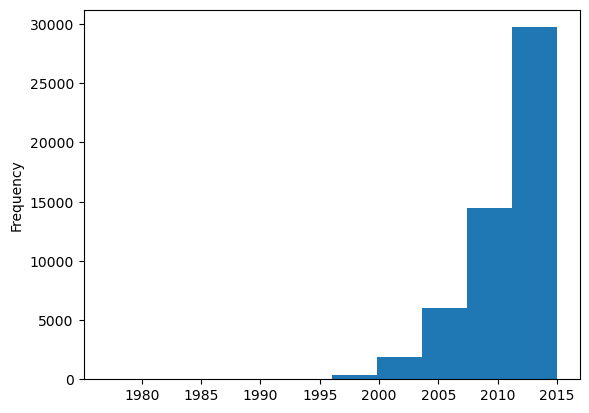

In [285]:
ds_train_prep['year_first_funding_at'].plot(kind='hist')

In [286]:
display(ds_train_prep.head(5))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,year_founded_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998,1M,2011,2014,2009
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748,100M,2010,2014,2005
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,4383,100M,2012,2014,2006
3,Sancilio and Company,Health Care,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,2011-09-01,2014-07-18,NaT,5114,100M,2011,2014,2004
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2791,Zero,2012,2012,2010


Добавим также признак сколько месяцев прошло между появлением стартапа и первым раундом финансирования.

In [287]:


ds_train_prep["months_diff"] = round(
    ((ds_train_prep['first_funding_at'] - ds_train_prep['founded_at']).dt.days
    )/30 ).astype(int) 

In [288]:
display(ds_train_prep.head(5))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,year_founded_at,months_diff
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998,1M,2011,2014,2009,19
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748,100M,2010,2014,2005,65
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,4383,100M,2012,2014,2006,81
3,Sancilio and Company,Health Care,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,2011-09-01,2014-07-18,NaT,5114,100M,2011,2014,2004,93
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2791,Zero,2012,2012,2010,21


#### Создадим дополнительные признаки у ds_test_prep

Разделим признак **funding_total_usd** на сегменты с осечками 0, 1000, 10K, 100K, 1M, 10M, 100M, 100M+.
Назовём их: 'Zero', '1k', '10k', '1M','10M', '100M', '100M_plus'

In [289]:
ds_test_prep = f_usd_segment(ds_test_prep)

In [290]:
ds_test_prep['year_first_funding_at'] = ds_test_prep['first_funding_at'].dt.year.astype(int) 
ds_test_prep['year_last_funding_at'] = ds_test_prep['last_funding_at'].dt.year.astype(int) 
# сразу заполним год, пропуская шаг записи полной даты основания
ds_test_prep['year_founded_at'] = ds_test_prep ['lifetime'].astype(int).apply(lambda x: f_lifetime_to_year('2018-01-01',x))
display(ds_test_prep.head(5))

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,founded_at,funding_usd_segment,year_first_funding_at,year_last_funding_at,year_founded_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,3501,2008-06-01,10M,2009,2009,2008
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2010-07-25,Zero,2010,2010,2010
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2014-06-16,1M,2014,2014,2014
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,2005-01-01,100M,2005,2010,2005
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,2001-01-01,10M,2007,2007,2001


Признак **category_list** имеет слишком много вариантов. Сделаем новый признак **main_category** и запишем в него для каждой компании первую указанную категорию

In [291]:
ds_train_prep['main_category'] = ds_train_prep['category_list'].astype(str).apply(lambda x: f_string_cuter(x, '|'))
ds_test_prep['main_category'] = ds_test_prep['category_list'].astype(str).apply(lambda x: f_string_cuter(x, '|'))

In [292]:
ds_test_prep.info()
ds_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          13125 non-null  object        
 2   funding_total_usd      13125 non-null  float64       
 3   country_code           13125 non-null  object        
 4   state_code             13125 non-null  object        
 5   region                 13125 non-null  object        
 6   city                   13125 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  founded_at             13125 non-null  datetime64[ns]
 12  funding_usd_segment    13125 non-null  category      
 13  y

In [293]:
#ds_test_prep['main_category'].value_counts(ascending=True).head(30)

In [294]:
ds_test_prep['main_category'] = ds_test_prep['main_category'].str.replace('nan', 'Other')

In [295]:
ds_test_prep.info()
ds_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          13125 non-null  object        
 2   funding_total_usd      13125 non-null  float64       
 3   country_code           13125 non-null  object        
 4   state_code             13125 non-null  object        
 5   region                 13125 non-null  object        
 6   city                   13125 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  founded_at             13125 non-null  datetime64[ns]
 12  funding_usd_segment    13125 non-null  category      
 13  y

Создадим признак количества месяцев между созданием стартапа и первым раундом финансирования.

In [296]:
ds_test_prep["months_diff"] = round(
    ((ds_test_prep['first_funding_at'] - ds_test_prep['founded_at']).dt.days
    )/30 ).astype(int) 

In [297]:
ds_test_prep.info()
ds_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          13125 non-null  object        
 2   funding_total_usd      13125 non-null  float64       
 3   country_code           13125 non-null  object        
 4   state_code             13125 non-null  object        
 5   region                 13125 non-null  object        
 6   city                   13125 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  founded_at             13125 non-null  datetime64[ns]
 12  funding_usd_segment    13125 non-null  category      
 13  y

<Axes: ylabel='Frequency'>

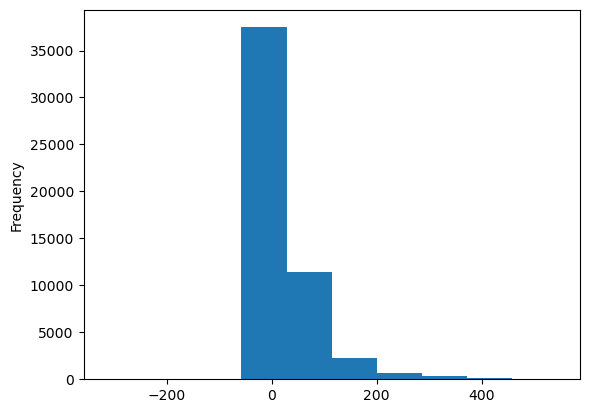

In [298]:
ds_train_prep['months_diff'].plot(kind='hist')

In [299]:
#display(ds_train_prep.loc[ds_train_prep['months_diff'] <0])

ds_train_prep['months_diff']. describe()

count    52516.000000
mean        32.814818
std         55.010650
min       -316.000000
25%          7.000000
50%         16.000000
75%         33.000000
max        544.000000
Name: months_diff, dtype: float64

Таких странных записей с отрицательной разницей в месяцах немного, занулим эту разницу.


In [300]:
ds_train_prep['months_diff'].loc[ds_train_prep['months_diff'] <0] = 0
ds_test_prep['months_diff'].loc[ds_test_prep['months_diff'] <0] = 0

In [301]:
ds_train_prep['months_diff']. describe()

count    52516.000000
mean        33.347799
std         54.465681
min          0.000000
25%          7.000000
50%         16.000000
75%         33.000000
max        544.000000
Name: months_diff, dtype: float64

In [302]:
ds_test_prep['months_diff']. describe()

count    13125.000000
mean        30.788495
std         53.385021
min          0.000000
25%          4.000000
50%         14.000000
75%         30.000000
max        530.000000
Name: months_diff, dtype: float64

#### Сделаем столбцы для каждой категории.

In [303]:
def to_camel_case(s):
    # Разделяем строку на слова по пробелам или нижним подчеркиваниям
    words = s.replace('_', ' ').split()
    # Первое слово оставляем в нижнем регистре
    camel_case = words[0].lower()
    # Остальные слова начинаем с заглавной буквы
    for word in words[1:]:
        camel_case += word.capitalize()
    return camel_case
######################################3
import re
def to_snake_case(s):
    # Вставляем нижнее подчеркивание перед заглавными буквами и переводим в нижний регистр
    s = re.sub('([A-Z])', r'_\1', s).lower()
    # Убираем возможные двойные подчеркивания
    s = re.sub('_+', '_', s)
    # Убираем подчеркивание в начале строки, если оно есть
    s = s.lstrip('_')
    return s

In [304]:

ds_test_prep['main_category'] = ds_test_prep['main_category'].apply(to_camel_case)
ds_train_prep['main_category'] = ds_train_prep['main_category'].apply(to_camel_case)

#ds_test_prep['main_category'] = ds_test_prep['main_category'].apply(to_snake_case)
#ds_train_prep['main_category'] = ds_train_prep['main_category'].apply(to_snake_case)

#display(ds_test_prep['main_category'].unique())

In [305]:

# Получаем уникальные значения из списка
unique_values_test = ds_test_prep['main_category'].unique()
unique_values_train = ds_train_prep['main_category'].unique()

####################3
# Преобразуем массивы в списки и объединяем
combined_list = list(unique_values_test) + list(unique_values_train)

# Удаляем дубликаты
combined_unique = list(set(combined_list))
print(combined_unique)


['fmcg', 'officeSpace', 'seniorCitizens', 'fashion', 'fuels', 'productSearch', 'freemium', 'ticketing', 'cloudManagement', 'electricVehicles', 'governance', 'leadGeneration', 'apps', 'crowdfunding', 'interfaceDesign', 'sns', 'projectManagement', 'infrastructure', 'mensSpecific', 'mobileAdvertising', 'internetTv', 'applicationPerformanceMonitoring', 'locationBasedServices', 'personalFinance', 'crowdsourcing', 'healthServicesIndustry', 'commodities', 'gameMechanics', 'social+Mobile+Local', 'predictiveAnalytics', 'marketplaces', 'sensors', 'semiconductorManufacturingEquipment', 'imageRecognition', 'oil', 'ediscovery', 'dataPrivacy', 'agriculture', 'biotechnology', 'innovationEngineering', 'displays', 'socialCrm', 'meetingSoftware', 'other', 'classifieds', 'email', 'diy', 'highSchools', 'innovationManagement', 'automatedKiosk', 'businessProductivity', 'realtors', 'naturalGasUses', 'rfid', 'healthCareInformationTechnology', 'cloudComputing', 'socialNews', 'personalBranding', 'wineAndSpirits

In [306]:
import warnings
warnings.filterwarnings('ignore')
# Создаем новые столбцы
for value in combined_unique:
    ds_test_prep[value] = (ds_test_prep['main_category'] == value).astype(int)  # Присваиваем 1, если условие выполняется, иначе 0

display(ds_test_prep)


for value in combined_unique:
    ds_train_prep[value] = (ds_train_prep['main_category'] == value).astype(int)  # Присваиваем 1, если условие выполняется, иначе 0
    
display(ds_train_prep)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
0,Crystalsol,Clean Technology,2819200.0,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,...,0,0,0,0,0,0,0,0,0,0
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,0,0,0,0,0,0,0,0,0,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,0,0,0,0,0,0,0,0,0,0
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,0,0,0,0,0,0,0,0,0,0
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,...,0,0,0,0,0,0,0,0,0,0
13121,GlobaTrek,Software,0.0,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,...,0,0,0,0,0,0,0,0,0,0
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,...,0,0,0,0,0,0,0,0,0,0
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,...,0,0,0,0,0,0,0,0,0,0


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,0,0
3,Sancilio and Company,Health Care,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,...,0,0,0,0,0,0,0,0,0,0
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,0.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,...,0,0,0,0,0,0,0,0,0,0
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,...,0,0,0,0,0,0,0,0,0,0
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,...,0,0,0,0,0,0,0,0,0,0
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,...,0,0,0,0,0,0,0,0,0,0


In [307]:
#test2['category_type'].value_counts(ascending=True).head(30)

display(ds_test_prep.head())

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
0,Crystalsol,Clean Technology,2819200.0,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,...,0,0,0,0,0,0,0,0,0,0
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,0,0,0,0,0,0,0,0,0,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,0,0,0,0,0,0,0,0,0,0
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,0,0,0,0,0,0,0,0,0,0
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,0,0,0,0,0,0,0,0,0,0


In [308]:
#ds_test_prep['main_category'].value_counts(ascending=True).head(30)

In [309]:
ds_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Columns: 752 entries, name to taxis
dtypes: category(1), datetime64[ns](3), float64(1), int64(740), object(7)
memory usage: 75.2+ MB


<Axes: ylabel='Frequency'>

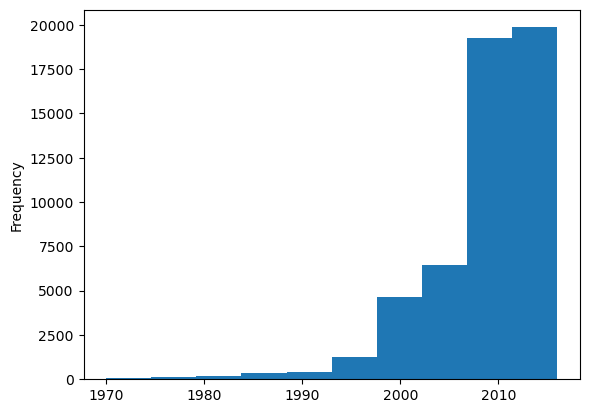

In [310]:
ds_train_prep['year_founded_at'].plot(kind='hist')

<Axes: ylabel='Frequency'>

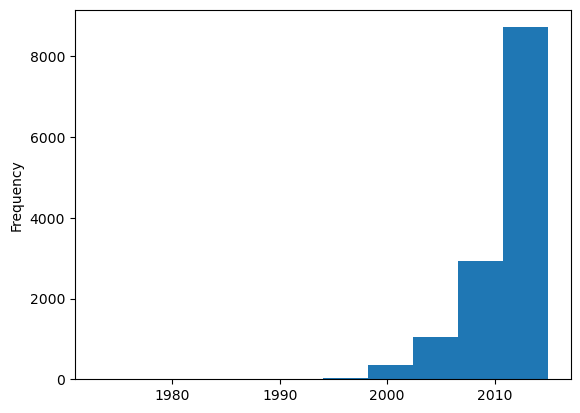

In [311]:
ds_test_prep['year_first_funding_at'].plot(kind='hist')

<Axes: ylabel='Frequency'>

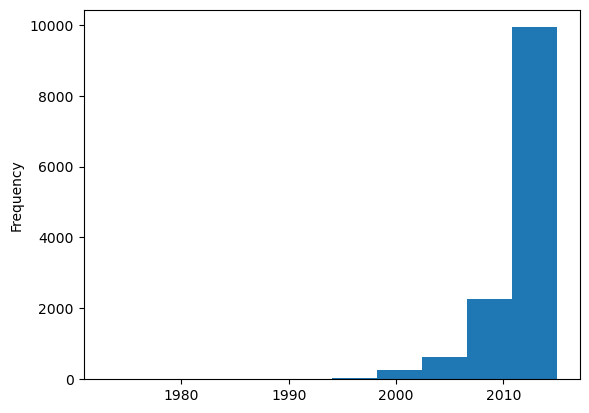

In [312]:
ds_test_prep['year_last_funding_at'].plot(kind='hist')

<Axes: ylabel='Frequency'>

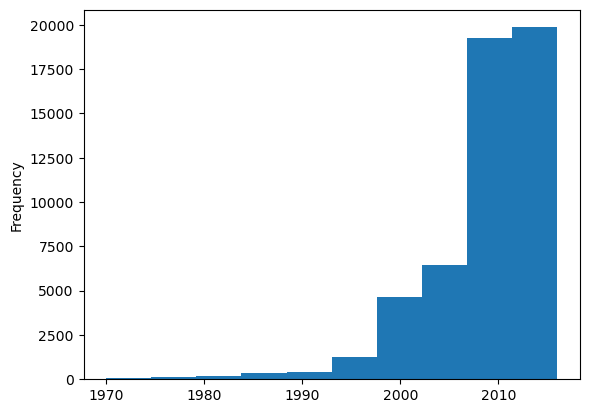

In [313]:
ds_train_prep['year_founded_at'].plot(kind='hist')

In [314]:
display(ds_train_prep.info())
display(ds_train_prep.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 754 entries, name to taxis
dtypes: category(1), datetime64[ns](4), float64(1), int64(740), object(8)
memory usage: 301.8+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,0,0
3,Sancilio and Company,Health Care,2.225000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2004-01-01,...,0,0,0,0,0,0,0,0,0,0
4,WireTough Cylinders,Manufacturing,0.000000e+00,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,0,0,0,0,0,0,0,0
5,Connected Sports Ventures,Mobile,4.300000e+06,operating,USA,NJ,Newark,Princeton,1,2011-04-16,...,0,0,0,0,0,0,0,0,0,0
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,9.000000e+07,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,...,0,0,0,0,0,0,0,0,0,0
7,Mesh Networks,Software,4.300000e+06,operating,USA,TX,Houston,Houston,1,2005-01-01,...,0,0,0,0,0,0,0,0,0,0
8,AngioScore,Biotechnology,4.200000e+07,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,...,0,0,0,0,0,0,0,0,0,0
9,Vidatronic,Semiconductors,1.250500e+06,operating,USA,TX,Austin,College Station,2,2010-01-01,...,0,0,0,0,0,0,0,0,0,0


In [315]:
display(ds_test_prep.info())
display(ds_test_prep.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Columns: 752 entries, name to taxis
dtypes: category(1), datetime64[ns](3), float64(1), int64(740), object(7)
memory usage: 75.2+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,SF Bay Area,San Francisco,1,2009-07-01,2009-07-01,...,0,0,0,0,0,0,0,0,0,0
1,JBI Fish & Wings,Hospitality,0.000000e+00,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,0,0,0,0,0,0,0,0,0,0
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,0,0,0,0,0,0,0,0,0,0
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,0,0,0,0,0,0,0,0,0,0
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,0,0,0,0,0,0,0,0,0,0
5,Quickfire Games,Design|Entertainment|Games,1.600000e+05,USA,CA,SF Bay Area,San Francisco,2,2013-09-18,2014-09-18,...,0,0,0,0,0,0,0,0,0,0
6,Sente Inc.,Biotechnology,2.684200e+07,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,...,0,0,0,0,0,0,0,0,0,0
7,Triosyn,Health Care|Medical|Therapeutics,4.000000e+06,USA,CA,SF Bay Area,San Francisco,1,2003-06-02,2003-06-02,...,0,0,0,0,0,0,0,0,0,0
8,Urgent.ly,Software,8.710000e+06,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,...,0,0,0,0,0,0,0,0,0,0
9,Map Decisions,Software,1.320000e+04,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,...,0,0,0,0,0,0,0,0,0,0


## Построим графики по подготовленным и заполненным данным.

### Посмотрим на графики ds_train_prep

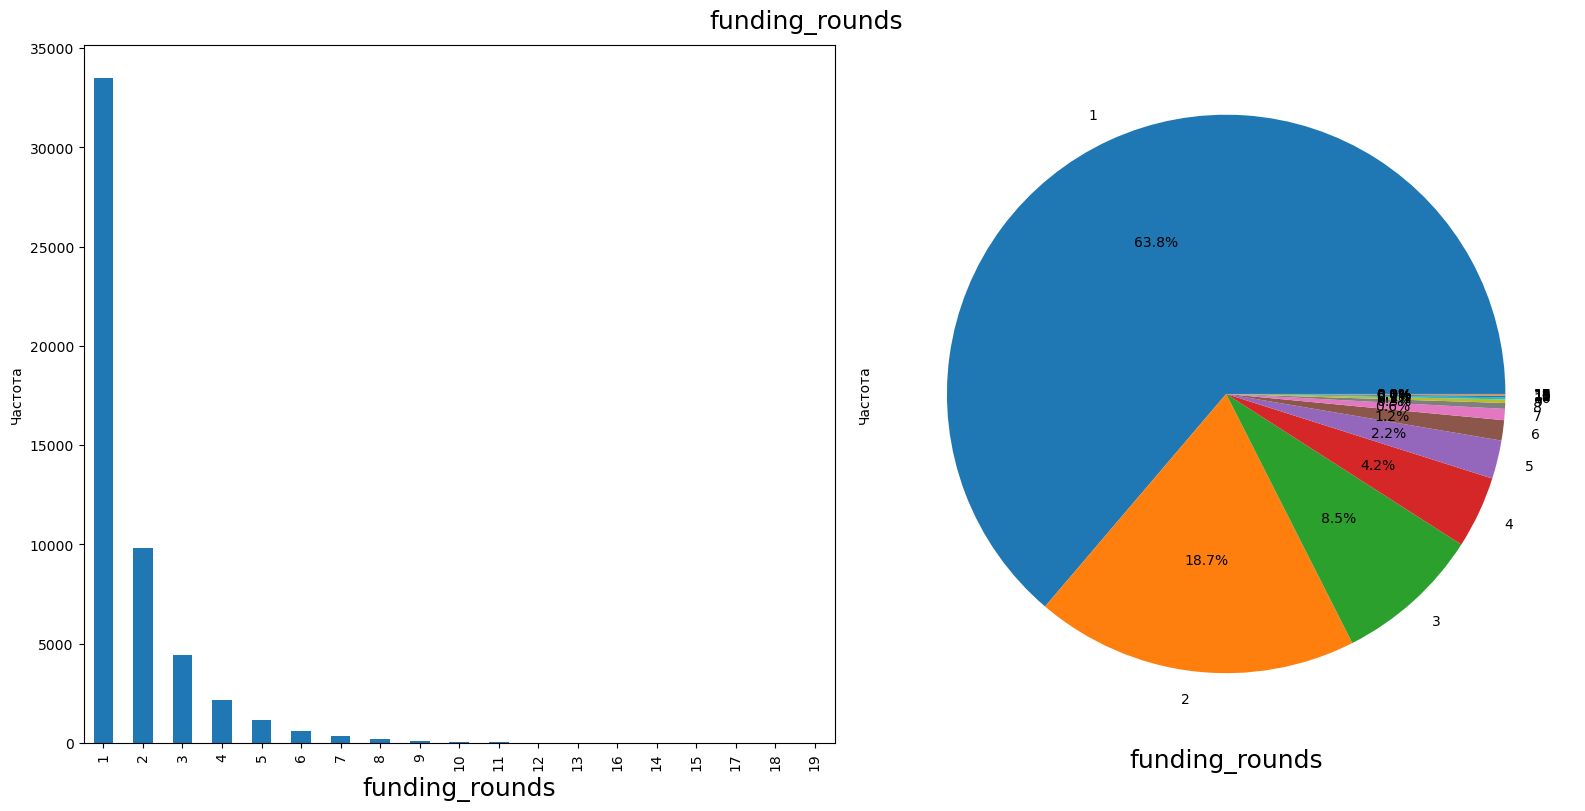

In [316]:
bar_and_pie(ds_train_prep, 'funding_rounds','funding_rounds')

63.8% компаний дошли только до первого раунда финансирования. 7 раундов и более име.т менее 1% сратрапов. 

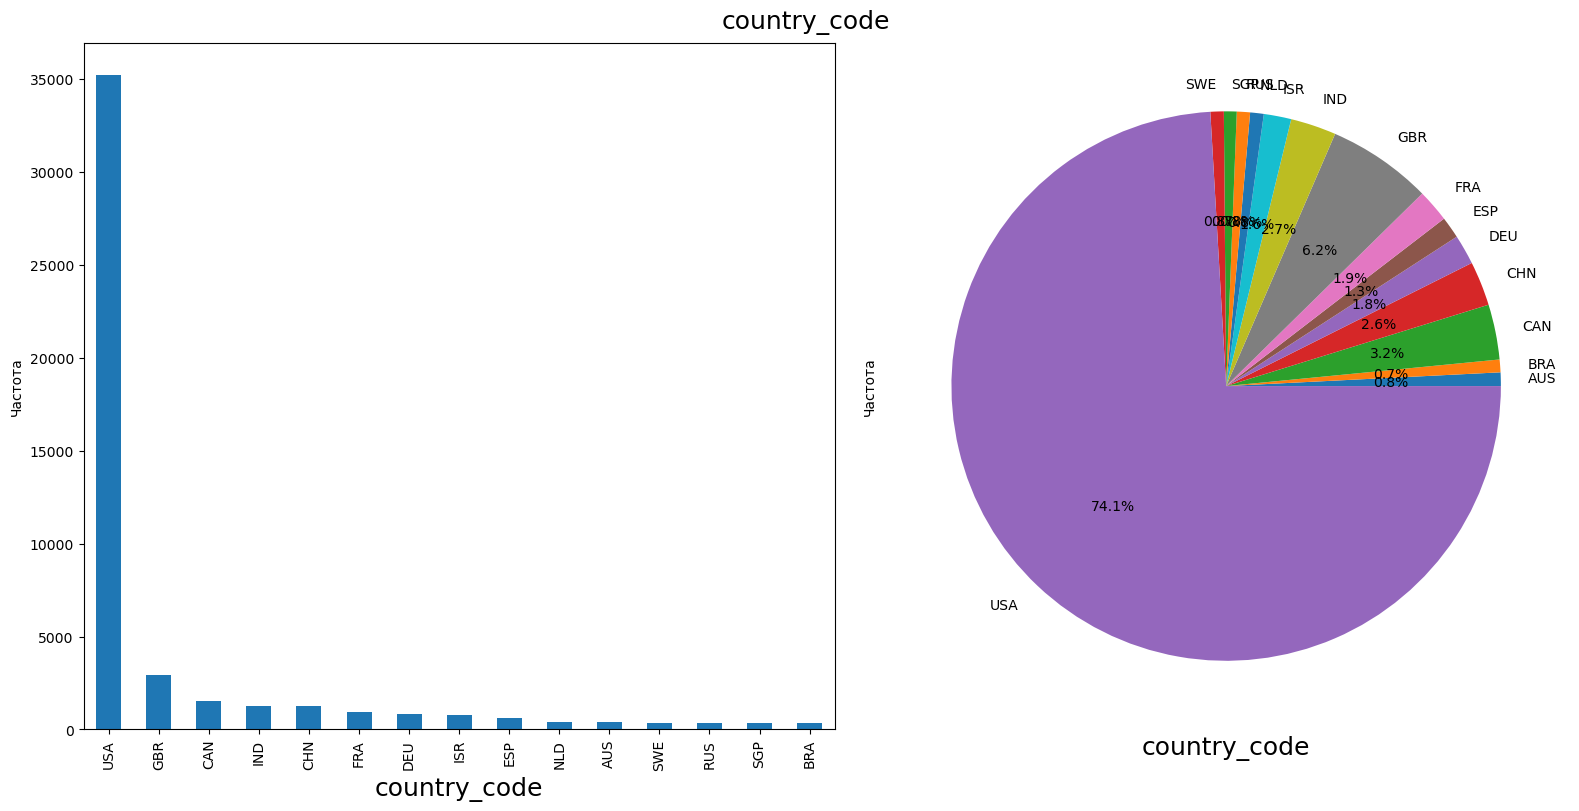

In [317]:
df_filtered = f_df_filtering(ds_train_prep, 'country_code', 15)
bar_and_pie(df_filtered, 'country_code','country_code')

США с 74.1% доминирует в списке компаний.

In [318]:
### Посмотрим на графики ds_test_prep

## Оптимизация

Уберём строки которые не помогут нам в обучении

In [319]:
ds_sample_prep.set_index('name', drop=True, inplace=True)
ds_train_prep.set_index('name', drop=True, inplace=True)
ds_test_prep.set_index('name', drop=True, inplace=True)

In [320]:
#   Удалим все пустые  строки из наборов данных.
ds_train_prep = ds_train_prep.drop(
    [
        'category_list', 
        'founded_at', 
        'first_funding_at', 
        'last_funding_at', 
        'closed_at',
        'main_category',
        'funding_total_usd',
 #       'state_code',
 #       'region',        
    ]
    , axis=1)


ds_test_prep = ds_test_prep.drop(
    [
        'category_list', 
        'founded_at', 
        'first_funding_at', 
        'last_funding_at', 
#        'closed_at',
        'main_category',
        'funding_total_usd',
#        'state_code',
#        'region',         
    ]
    , axis=1)    


In [321]:
display(ds_train_prep.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Columns: 746 entries, status to taxis
dtypes: category(1), int64(740), object(5)
memory usage: 298.9+ MB


None

In [322]:
display(ds_train_prep.head(5))


,status,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
name,,,,,,,,,,,,,,,,,,,,,
Lunchgate,operating,CHE,25,Zurich,Zürich,2,2998,1M,2011,2014,...,0,0,0,0,0,0,0,0,0,0
EarLens,operating,USA,CA,SF Bay Area,Redwood City,4,4748,100M,2010,2014,...,0,0,0,0,0,0,0,0,0,0
Reviva Pharmaceuticals,operating,USA,CA,SF Bay Area,San Jose,3,4383,100M,2012,2014,...,0,0,0,0,0,0,0,0,0,0
Sancilio and Company,operating,USA,CA,SF Bay Area,San Francisco,3,5114,100M,2011,2014,...,0,0,0,0,0,0,0,0,0,0
WireTough Cylinders,operating,USA,VA,VA - Other,Bristol,1,2791,Zero,2012,2012,...,0,0,0,0,0,0,0,0,0,0


In [323]:
display(ds_test_prep.head(5))

,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,year_founded_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
name,,,,,,,,,,,,,,,,,,,,,
Crystalsol,NIC,17,SF Bay Area,San Francisco,1,3501,10M,2009,2009,2008,...,0,0,0,0,0,0,0,0,0,0
JBI Fish & Wings,USA,TN,TN - Other,Humboldt,1,2717,Zero,2010,2010,2010,...,0,0,0,0,0,0,0,0,0,0
COINPLUS,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,1295,1M,2014,2014,2014,...,0,0,0,0,0,0,0,0,0,0
Imagine Communications,USA,CA,San Diego,San Diego,4,4748,100M,2005,2010,2005,...,0,0,0,0,0,0,0,0,0,0
DNA13,CAN,ON,Ottawa,Ottawa,1,6209,10M,2007,2007,2001,...,0,0,0,0,0,0,0,0,0,0


На данном этапе обработаны все пропуски, добавлены дополнительные признаки, удалены признакие не участвующие в обучении.

In [324]:
df_short_view(ds_train_prep)

Размер таблицы: (52516, 746)

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Columns: 746 entries, status to taxis
dtypes: category(1), int64(740), object(5)
memory usage: 298.9+ MB
None

status                    0
country_code              0
state_code                0
region                    0
city                      0
                         ..
internetMarketing         0
communicationsHardware    0
search                    0
videoGames                0
taxis                     0
Length: 746, dtype: int64


,status,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
name,,,,,,,,,,,,,,,,,,,,,
Lunchgate,operating,CHE,25,Zurich,Zürich,2,2998,1M,2011,2014,...,0,0,0,0,0,0,0,0,0,0
EarLens,operating,USA,CA,SF Bay Area,Redwood City,4,4748,100M,2010,2014,...,0,0,0,0,0,0,0,0,0,0
Reviva Pharmaceuticals,operating,USA,CA,SF Bay Area,San Jose,3,4383,100M,2012,2014,...,0,0,0,0,0,0,0,0,0,0
Sancilio and Company,operating,USA,CA,SF Bay Area,San Francisco,3,5114,100M,2011,2014,...,0,0,0,0,0,0,0,0,0,0
WireTough Cylinders,operating,USA,VA,VA - Other,Bristol,1,2791,Zero,2012,2012,...,0,0,0,0,0,0,0,0,0,0


In [325]:
df_short_view(ds_test_prep)


Размер таблицы: (13125, 745)

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Columns: 745 entries, country_code to taxis
dtypes: category(1), int64(740), object(4)
memory usage: 74.6+ MB
None

country_code              0
state_code                0
region                    0
city                      0
funding_rounds            0
                         ..
internetMarketing         0
communicationsHardware    0
search                    0
videoGames                0
taxis                     0
Length: 745, dtype: int64


,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,year_founded_at,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
name,,,,,,,,,,,,,,,,,,,,,
Crystalsol,NIC,17,SF Bay Area,San Francisco,1,3501,10M,2009,2009,2008,...,0,0,0,0,0,0,0,0,0,0
JBI Fish & Wings,USA,TN,TN - Other,Humboldt,1,2717,Zero,2010,2010,2010,...,0,0,0,0,0,0,0,0,0,0
COINPLUS,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,1295,1M,2014,2014,2014,...,0,0,0,0,0,0,0,0,0,0
Imagine Communications,USA,CA,San Diego,San Diego,4,4748,100M,2005,2010,2005,...,0,0,0,0,0,0,0,0,0,0
DNA13,CAN,ON,Ottawa,Ottawa,1,6209,10M,2007,2007,2001,...,0,0,0,0,0,0,0,0,0,0


## Проверим колинеарность с помощью  phik_matrix

In [326]:
#corr_heatmap(ds_train_prep,14,10, 'spearman', drop_columns=['closed_at'])

In [327]:
phik_overview = ds_train_prep.head(10000).phik_matrix(interval_cols=['lifetime', 'funding_total_usd'])
display(phik_overview)

,status,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,...,dataIntegration,riskManagement,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
status,1.000000,0.111441,0.151844,0.128000,0.000000,0.121975,0.549849,0.079263,0.198342,0.261424,...,0.000000,0.0,0.000000,0.015059,0.0,0.000000,0.0,0.027108,0.0,0.000000
country_code,0.111441,1.000000,0.991973,0.999978,0.999930,0.000000,0.000000,0.304168,0.000000,0.000000,...,0.240374,0.0,0.000000,0.077867,0.0,0.000000,0.0,0.272456,0.0,0.089828
state_code,0.151844,0.991973,1.000000,0.999894,0.999984,0.114629,0.115641,0.232270,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.467962,0.0,0.000000,0.0,0.000000
region,0.128000,0.999978,0.999894,1.000000,1.000000,0.000000,0.431655,0.412316,0.000000,0.000000,...,0.082763,0.0,0.119637,0.000000,0.0,0.479767,0.0,0.000000,0.0,0.000000
city,0.000000,0.999930,0.999984,1.000000,1.000000,0.000000,0.765734,0.570353,0.810658,0.821462,...,0.000000,0.0,0.757490,0.000000,0.0,0.357410,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
internetMarketing,0.000000,0.000000,0.467962,0.479767,0.357410,0.000000,0.000000,0.019171,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000
communicationsHardware,0.000000,0.000000,0.000000,0.000000,0.000000,0.102980,0.056610,0.048240,0.042366,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000
search,0.027108,0.272456,0.000000,0.000000,0.000000,0.000000,0.010548,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000
videoGames,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000


In [328]:
display(phik_overview['status'].loc[ phik_overview['status'] > 0.05].sort_values(ascending=False))



status                   1.000000
lifetime                 0.549849
year_last_funding_at     0.261424
other                    0.234169
year_first_funding_at    0.198342
state_code               0.151844
year_founded_at          0.143143
region                   0.128000
funding_rounds           0.121975
country_code             0.111441
curatedWeb               0.100734
funding_usd_segment      0.079263
applicationPlatforms     0.067193
coupons                  0.058647
Name: status, dtype: float64

Видно что на статус оказывают сильное влияние **lifetime**. Но у новых компаний он будет небольшой.

    Так же заметное влияние оказывают все даты: годы первого , последнего инвестиционных раундов и год основания компании.
    Влияет регион, код страны и код штата.
    Влияет указанная категория компании. Особенно **other** и **curatedWeb**
    Количество раундов финансирования и принадлежность      
    

In [329]:
# Выбор строк, где хотя бы одно значение больше 0.9
result = phik_overview[phik_overview > 0.9].any(axis=1)
filtered_df = phik_overview[result]

result = filtered_df[filtered_df < 1].any(axis=1)
filtered_df = phik_overview[result]

display(filtered_df)

,status,country_code,state_code,region,city,funding_rounds,lifetime,funding_usd_segment,year_first_funding_at,year_last_funding_at,...,dataIntegration,riskManagement,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
status,1.000000,0.111441,0.151844,0.128000,0.000000,0.121975,0.549849,0.079263,0.198342,0.261424,...,0.000000,0.0,0.000000,0.015059,0.0,0.000000,0.0,0.027108,0.0,0.000000
country_code,0.111441,1.000000,0.991973,0.999978,0.999930,0.000000,0.000000,0.304168,0.000000,0.000000,...,0.240374,0.0,0.000000,0.077867,0.0,0.000000,0.0,0.272456,0.0,0.089828
state_code,0.151844,0.991973,1.000000,0.999894,0.999984,0.114629,0.115641,0.232270,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.467962,0.0,0.000000,0.0,0.000000
region,0.128000,0.999978,0.999894,1.000000,1.000000,0.000000,0.431655,0.412316,0.000000,0.000000,...,0.082763,0.0,0.119637,0.000000,0.0,0.479767,0.0,0.000000,0.0,0.000000
city,0.000000,0.999930,0.999984,1.000000,1.000000,0.000000,0.765734,0.570353,0.810658,0.821462,...,0.000000,0.0,0.757490,0.000000,0.0,0.357410,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
activeLifestyle,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000
internetMarketing,0.000000,0.000000,0.467962,0.479767,0.357410,0.000000,0.000000,0.019171,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000
communicationsHardware,0.000000,0.000000,0.000000,0.000000,0.000000,0.102980,0.056610,0.048240,0.042366,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000
search,0.027108,0.272456,0.000000,0.000000,0.000000,0.000000,0.010548,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000


In [330]:
ds_train_prep['country_code'].value_counts()

country_code
USA    35204
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

In [331]:
ds_test_prep['city'].value_counts()

city
San Francisco        2243
New York              641
London                384
Austin                159
Palo Alto             155
                     ... 
Aix-en-provence         1
Croissy-beaubourg       1
Norfolk                 1
Wayzata                 1
Taichung                1
Name: count, Length: 2117, dtype: int64

In [332]:
#funding_total_usd
display(ds_train_prep.describe())

,funding_rounds,lifetime,year_first_funding_at,year_last_funding_at,year_founded_at,months_diff,fmcg,officeSpace,seniorCitizens,fashion,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
count,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.0,52516.000000,52516.000000,52516.000000,...,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000
mean,1.740670,3140.828129,2011.075691,2012.012491,2008.560096,33.347799,0.0,0.000057,0.000019,0.007122,...,0.000229,0.000057,0.000152,0.000152,0.000457,0.000800,0.000571,0.002761,0.000171,0.000038
std,1.374522,2147.821070,3.613547,3.336599,5.756683,54.465681,0.0,0.007558,0.004364,0.084090,...,0.015115,0.007558,0.012342,0.012342,0.021373,0.028269,0.023894,0.052474,0.013090,0.006171
min,1.000000,19.000000,1977.000000,1977.000000,1970.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1739.000000,2009.000000,2011.000000,2006.000000,7.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2557.000000,2012.000000,2013.000000,2010.000000,16.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,4018.000000,2014.000000,2014.000000,2013.000000,33.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,17378.000000,2015.000000,2015.000000,2016.000000,544.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [333]:
display(ds_test_prep.describe())

,funding_rounds,lifetime,year_first_funding_at,year_last_funding_at,year_founded_at,months_diff,fmcg,officeSpace,seniorCitizens,fashion,...,riskManagement,presentations,naturalResources,onlineEducation,activeLifestyle,internetMarketing,communicationsHardware,search,videoGames,taxis
count,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.0,13125.0,13125.000000,...,13125.0,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.0
mean,1.714438,3097.609524,2011.094324,2011.981410,2009.218590,30.788495,0.000152,0.0,0.0,0.007238,...,0.0,0.000076,0.000152,0.000076,0.000457,0.000838,0.000457,0.002895,0.000229,0.0
std,1.318800,2128.356554,3.644952,3.392035,5.744456,53.385021,0.012344,0.0,0.0,0.084772,...,0.0,0.008729,0.012344,0.008729,0.021377,0.028939,0.021377,0.053732,0.015117,0.0
min,1.000000,52.000000,1973.000000,1973.000000,1971.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1726.000000,2009.000000,2011.000000,2007.000000,4.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,2526.000000,2012.000000,2013.000000,2011.000000,14.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,3866.000000,2014.000000,2014.000000,2013.000000,30.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,15.000000,17167.000000,2015.000000,2015.000000,2017.000000,530.000000,1.000000,0.0,0.0,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [334]:
display(ds_train_prep.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Columns: 746 entries, status to taxis
dtypes: category(1), int64(740), object(5)
memory usage: 298.9+ MB


None

In [335]:
display(ds_test_prep.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Columns: 745 entries, country_code to taxis
dtypes: category(1), int64(740), object(4)
memory usage: 74.6+ MB


None

## Настройка пайплайнов

In [336]:
### Разбиение мсходных признаков по категориям

In [337]:
# Разделим все входные признаки на 3 группы
ohe_columns = [                                ## Сюда включаю в том числе столбцы которые числовые, но с ними нельзы оперировать вида " больше- лучше" . Делаю их пометками
#               'main_category', 
#               'year_first_funding_at',
#               'year_last_funding_at',
#               'year_founded_at',    
               'country_code',
               'state_code',
               'region',
               'city',
               'funding_usd_segment',
                'months_diff',
#                'category_type'
               ] # Категориальные признаки (OHE)
ord_columns = [
               'funding_rounds',
#               'funding_usd_segment',
#               'year_first_funding_at',
#               'year_last_funding_at',
#               'year_founded_at'
              ] # Ordinal (перевести строковые категории в числа)

num_columns = [
                'lifetime', 
#                'funding_total_usd', 
#                'year_first_funding_at',
#               'year_last_funding_at',
#               'year_founded_at'
                ]


#num_columns = df_merged.select_dtypes(include=['number']).columns
# проверяем список
#print(num_columns#ohe_columns = df.select_dtypes(include=['object']).columns

In [338]:
#   Удалим все пустые  строки из наборов данных.
ds_train_prep = ds_train_prep.drop(
    [
        'year_first_funding_at', 
       'year_last_funding_at',
        'year_founded_at',  
    ]
    , axis=1)


ds_test_prep = ds_test_prep.drop(
    [
        'year_first_funding_at', 
       'year_last_funding_at',
        'year_founded_at',  
    ]
    , axis=1)    


In [339]:
display(ds_train_prep.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Columns: 743 entries, status to taxis
dtypes: category(1), int64(737), object(5)
memory usage: 297.7+ MB


None

### Разбиение данных на выборки

In [340]:
# Объявим константу random_state
RANDOM_STATE = 42

# Выделим целевой и входные признаки
y = ds_train_prep['status']
X = ds_train_prep.drop(['status'], axis = 1)

# Разделим данные на тренировочную и тестовую выборки
X_train, X_validation, y_train, y_validation = train_test_split(
#(X, y, train_size=0.75, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,  
        stratify = y,    
)

#X_train = ds_train_prep.drop(['status'], axis = 1)
#y_train = ds_train_prep['status']

X_test  = ds_test_prep
y_test  = ds_sample_prep

# Проверим размеры получившихся выборок
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape)
print('Размер выборки для целевых признаков тестовой выборки:', y_test.shape)
print()
print('Размер валидационной выборки:', X_validation.shape)
print('Размер выборки для целевых признаков валидационно выборки:', y_validation.shape)
#print('Размер исходного набора данных',df_merged.shape)

Размер тренировочной выборки: (39387, 742)
Размер тестовой выборки: (13125, 742)
Размер выборки для целевых признаков тренировочной выборки: (39387,)
Размер выборки для целевых признаков тестовой выборки: (13125, 1)

Размер валидационной выборки: (13129, 742)
Размер выборки для целевых признаков валидационно выборки: (13129,)


In [341]:
display(y_validation.head())

name
VISIOGROUP SAS    operating
VulevÃº           operating
myCREOpoint       operating
SWEEPiO           operating
Mix & Meet           closed
Name: status, dtype: object

In [342]:
display(type(X_train))
display(type(y_train))
display(type(X_test))
display(type(y_test))
print()
display(type(X_validation))
display(type(y_validation))

pandas.core.frame.DataFrame

pandas.core.series.Series

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

pandas.core.series.Series

In [343]:
#y_test = pd.DataFrame(y_test)
#y_train = pd.DataFrame(y_train)

In [344]:
display('y_train')
display(type(y_train))
display(y_train)

'y_train'

pandas.core.series.Series

name
Startlocal             operating
Full Spectrum Laser    operating
Waywire Networks       operating
VeryApt                operating
Vdancer                operating
                         ...    
Artesian Solutions     operating
Biomoda                operating
tracx                  operating
Foodspotting           operating
Edumoko                operating
Name: status, Length: 39387, dtype: object

In [345]:
display('y_test')
display(type(y_test))
display(y_test)

'y_test'

pandas.core.frame.DataFrame

,status
name,
Crystalsol,closed
JBI Fish & Wings,operating
COINPLUS,closed
Imagine Communications,closed
DNA13,operating
...,...
Jymob,operating
GlobaTrek,operating
Inkd.com,closed


### Кодировка целевого признака

In [346]:
# Создадим экземпляр класса LabelEncoder для кодирования целевого признака покупательская_активность в числовой формат
label_encoder = LabelEncoder()
# Обучим модель и трансформируем тренировочную выборку 
y_train_LE = label_encoder.fit_transform(y_train)

display(label_encoder.classes_)

# Трансформируем тестовую выборку

#y_test = pd.Series(y_test, copy=False)

y_test_LE = label_encoder.transform(y_test)

y_validation_LE = label_encoder.transform(y_validation)

#y_test = label_encoder.transform(y_test[:,0:1])

display(y_train_LE)
display(y_test_LE)
display(y_validation_LE)

display(type(y_train_LE))
display(type(y_test_LE))
display(type(y_validation_LE))


array(['closed', 'operating'], dtype=object)

array([1, 1, 1, ..., 1, 1, 1])

array([0, 1, 0, ..., 0, 1, 1])

array([1, 1, 1, ..., 1, 1, 1])

numpy.ndarray

numpy.ndarray

numpy.ndarray

In [347]:
#y_test_LE.value_counts()

In [348]:
#display(y_train)

In [349]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39387 entries, Startlocal to Edumoko
Columns: 742 entries, country_code to taxis
dtypes: category(1), int64(737), object(4)
memory usage: 223.0+ MB


In [350]:
X_train.columns

Index(['country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'funding_usd_segment', 'months_diff', 'fmcg', 'officeSpace',
       ...
       'riskManagement', 'presentations', 'naturalResources',
       'onlineEducation', 'activeLifestyle', 'internetMarketing',
       'communicationsHardware', 'search', 'videoGames', 'taxis'],
      dtype='object', length=742)

In [351]:
display(X_train.info())



<class 'pandas.core.frame.DataFrame'>
Index: 39387 entries, Startlocal to Edumoko
Columns: 742 entries, country_code to taxis
dtypes: category(1), int64(737), object(4)
memory usage: 223.0+ MB


None

## CatBoost

In [352]:
#display(cat_features)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39387 entries, Startlocal to Edumoko
Columns: 742 entries, country_code to taxis
dtypes: category(1), int64(737), object(4)
memory usage: 223.0+ MB


In [353]:
#X_train.columns
#cat_features = [1, 2, 3, 4, 7,8,9,10]
#cat_features = [1, 2, 3, 4, 10]

cat_features = ohe_columns
#cat_features = X_train.select_dtypes(include=['object']).columns

# Создание и обучение модели с указанием категориальных признаков
#model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)

model_cb1 = CatBoostClassifier(
    custom_metric = ['F1', 'AUC'], 
    eval_metric='F1', 
    iterations=5000, 
    verbose=100,
    depth=10, 
    learning_rate=0.01,
    l2_leaf_reg=1,
    loss_function = 'Logloss',
)
model_cb1.fit(
    X_train, 
    y_train_LE, 
    cat_features=cat_features, 
#    verbose=False, 
#    eval_set=(X_validation, y_validation),

    plot=True
)
##model.fit(X_train, y_train, verbose=False)

# Оценка производительности модели
#accuracy = model_cb1.score(X_validation, y_validation_LE)
#print(f"Accuracy: {accuracy}")



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9717419	total: 65.1ms	remaining: 5m 25s
100:	learn: 0.9820685	total: 4.76s	remaining: 3m 51s
200:	learn: 0.9853053	total: 11.5s	remaining: 4m 33s
300:	learn: 0.9868110	total: 18.4s	remaining: 4m 46s
400:	learn: 0.9877025	total: 25.1s	remaining: 4m 47s
500:	learn: 0.9883197	total: 31.8s	remaining: 4m 45s
600:	learn: 0.9887996	total: 38.3s	remaining: 4m 39s
700:	learn: 0.9891298	total: 44.5s	remaining: 4m 33s
800:	learn: 0.9894731	total: 50.9s	remaining: 4m 26s
900:	learn: 0.9896512	total: 57.3s	remaining: 4m 20s
1000:	learn: 0.9897886	total: 1m 3s	remaining: 4m 14s
1100:	learn: 0.9900910	total: 1m 10s	remaining: 4m 8s
1200:	learn: 0.9904212	total: 1m 17s	remaining: 4m 3s
1300:	learn: 0.9907243	total: 1m 24s	remaining: 3m 59s
1400:	learn: 0.9910688	total: 1m 31s	remaining: 3m 54s
1500:	learn: 0.9913998	total: 1m 38s	remaining: 3m 49s
1600:	learn: 0.9916202	total: 1m 45s	remaining: 3m 44s
1700:	learn: 0.9919101	total: 1m 53s	remaining: 3m 39s
1800:	learn: 0.9921170	total: 2m	r

In [354]:
#y_pred_cb = model_cb1.predict(X_test)
#print('Факт по тестовой выборке')
#print(f"F1_score = {f1_score(y_test_LE, y_pred_cb)}")
#print(f"ROC_AUC_score = {roc_auc_score(y_test_LE, y_pred_cb)}")

# validations
print()
y_pred_cb_val = model_cb1.predict(X_validation)
print('Проверка на валидационной выборке')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_cb_val)}")
print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_cb_val)}")

# end of Validations

print()
display(model_cb1.get_best_score())

model_cb1.get_feature_importance(prettified=True).head(15)


План по валидационной выборке
F1_score_validation = 0.9889231281752311
ROC_AUC_score_validation = 0.9012672050105641



{'learn': {'Logloss': 0.022394046468578656, 'F1': 0.9967609527266635}}

,Feature Id,Importances
0,lifetime,30.397676
1,funding_rounds,25.467758
2,months_diff,21.410030
3,funding_usd_segment,3.749445
4,state_code,2.790614
5,city,2.469727
6,region,2.466318
7,country_code,2.071340
8,curatedWeb,0.973007
9,biotechnology,0.761544


In [150]:
#display( len(X_test.index))
#display( len(y_pred))

#print("Форма y_test:", y_test.shape)
##print("Форма y_pred:", y_pred.shape)

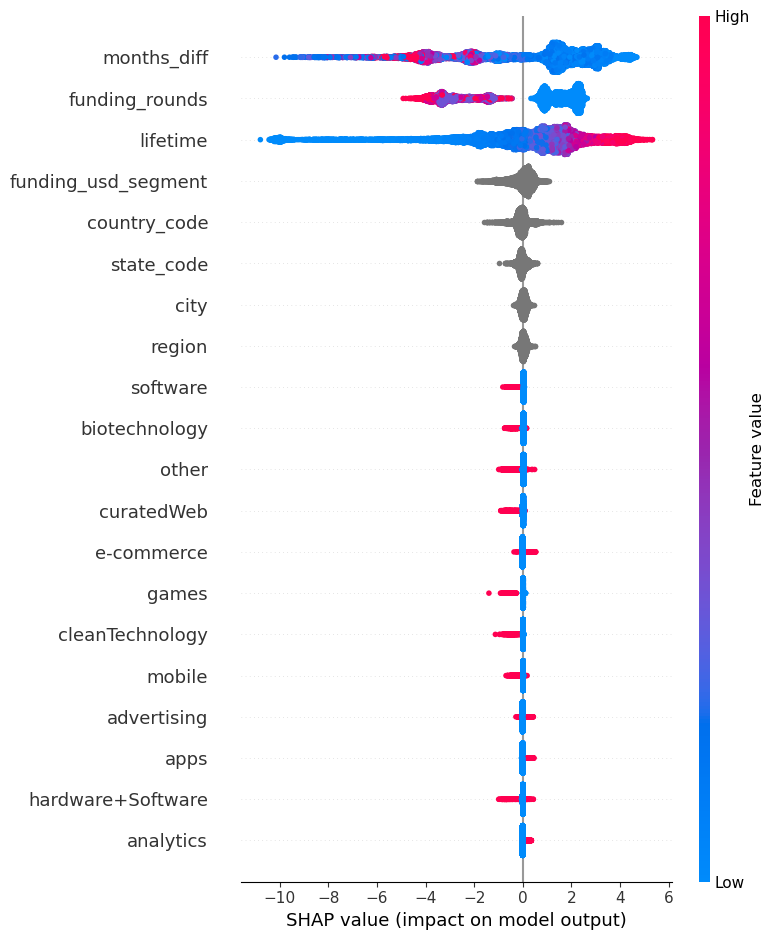

In [355]:

# Вычисляем SHAP-значения
explainer = shap.Explainer(model_cb1)
shap_values = explainer(X_validation)

# Визуализируем важность признаков
shap.summary_plot(shap_values, X_validation)

## CatBoostClassifier и RandomizedSearchCV

In [362]:
param_grid_cb = {
    'iterations': [200, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [ 8, 10,],
    'l2_leaf_reg': [1, 2, 4,],
    
    #'min_data_in_leaf': [2,4,6]
}
# Определяем модель
CBS = CatBoostClassifier(#random_state=42, 
                         cat_features=cat_features,
                         verbose=False, 
                         #early_stopping_rounds = 100,
                         early_stopping_rounds=50,
                        loss_function = 'Logloss',
                        eval_metric='F1',
                        )
# Создаем RandomizedSearchCV с verbose=10
random_search_cb = RandomizedSearchCV(
    estimator=CBS,
    param_distributions=param_grid_cb,
    n_iter=5,
    cv=5,
    verbose=10,  # Увеличиваем уровень детализации
    random_state=RANDOM_STATE,
    scoring='f1',
)


In [363]:
# Обучение
random_search_cb.fit(X_train, y_train_LE)
best_catboost_model = random_search_cb.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1.
[CV 1/5; 1/5] END depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1;, score=0.989 total time= 1.1min
[CV 2/5; 1/5] START depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1.
[CV 2/5; 1/5] END depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1;, score=0.988 total time=  59.4s
[CV 3/5; 1/5] START depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1.
[CV 3/5; 1/5] END depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1;, score=0.989 total time=  58.8s
[CV 4/5; 1/5] START depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1.
[CV 4/5; 1/5] END depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1;, score=0.989 total time= 1.1min
[CV 5/5; 1/5] START depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1.
[CV 5/5; 1/5] END depth=10, iterations=1000, l2_leaf_reg=4, learning_rate=0.1;, score=0.990

In [364]:
# validations
print()
y_pred_gscb_val = best_catboost_model.predict(X_validation)
print('План по валидационной выборке')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_gscb_val)}")
print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_gscb_val)}")


План по валидационной выборке
F1_score_validation = 0.988842631140716
ROC_AUC_score_validation = 0.8997238993237653


In [365]:
best_catboost_model.best_score_

{'learn': {'Logloss': 0.04645458797745132, 'F1': 0.9920749680218007}}

In [368]:
print()
display(best_catboost_model.get_best_score())

best_catboost_model.get_feature_importance(prettified=True).head(15)

{'learn': {'Logloss': 0.04645458797745132, 'F1': 0.9920749680218007}}

,Feature Id,Importances
0,lifetime,36.189157
1,funding_rounds,27.717924
2,months_diff,24.104218
3,funding_usd_segment,1.755959
4,state_code,1.123049
5,country_code,1.110485
6,region,1.030265
7,curatedWeb,0.954326
8,city,0.851985
9,other,0.444370


In [367]:
#import shap
#shap.summary_plot(shap_values, X)

#### Cоздаём пайплайны для разных типов данных

In [369]:
# создаём пайплайны для разных типов данных
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(
        drop='first', 
        handle_unknown='ignore', 
#        sparse=False
        sparse_output=False
    )
    )
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# объединяем пайплайны
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough', 
    force_int_remainder_cols=False  # Используем новый формат
                                     )

# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

pipe_rfc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

#### Cоздаём пайплайны для RandomForestClassifier

In [370]:
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rfc = {
    'n_estimators': [ 100,250, 500 , 1000],
#    'max_depth': [None, 10, 20, 30],

}


param_distributions_rfc = {
    'classifier__n_estimators': [50, 100, 250, 500],  # Указываем с префиксом classifier__
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,  10]
}

randomized_search_rfc= RandomizedSearchCV(
    #estimator=RandomForestClassifier,
    pipe_rfc,
#    param_grid_rfc,
    param_distributions_rfc,
    cv=5,
    n_iter=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose = 10,
#    max_features  ='sqrt',
    )

In [371]:
#grid_search_rfc.fit(X_train, y_train_LE)
#best_rfc_model = grid_search_rfc.best_estimator_
randomized_search_rfc.fit(X_train, y_train_LE)
best_rfc_model = randomized_search_rfc.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50
[CV 2/5; 1/5] START classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50
[CV 3/5; 1/5] START classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50
[CV 4/5; 1/5] START classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50
[CV 5/5; 1/5] START classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50
[CV 1/5; 2/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 1/5] END classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50;, score=0.951 total time=  31.8s
[CV 2/5; 1/5] END classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50;, score=0.951 total time=  31.5s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 1/5] END classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50;, score=0.951 total time=  32.1s
[CV 3/5; 2/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 1/5] END classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50;, score=0.951 total time=  31.6s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 2/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 1/5] END classifier__max_depth=20, classifier__min_samples_split=10, classifier__n_estimators=50;, score=0.951 total time=  31.7s
[CV 5/5; 2/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 3/5] START classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 2/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time= 1.0min
[CV 2/5; 3/5] START classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  59.7s
[CV 3/5; 3/5] START classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 2/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time= 1.0min
[CV 4/5; 2/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time= 1.0min
[CV 4/5; 3/5] START classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 2/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  59.9s
[CV 5/5; 3/5] START classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 4/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 4/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.951 total time=  30.6s
[CV 2/5; 4/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 4/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.951 total time=  30.4s
[CV 3/5; 4/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.977 total time= 2.4min
[CV 4/5; 4/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.951 total time=  30.8s
[CV 5/5; 4/5] START classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.975 total time= 2.4min
[CV 1/5; 5/5] START classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.951 total time=  30.5s
[CV 2/5; 5/5] START classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END classifier__max_depth=20, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.951 total time=  30.6s
[CV 3/5; 5/5] START classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.977 total time= 2.3min
[CV 4/5; 5/5] START classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.976 total time= 2.4min
[CV 5/5; 5/5] START classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 5/5] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  31.4s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.976 total time= 2.4min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  30.4s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/5] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  26.5s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 5/5] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  21.2s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.951 total time=  17.6s


In [372]:
y_pred_rfc = best_rfc_model.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy of Random Forest: {accuracy:.2f}')
# результаты
print('Лучшая модель и её параметры:\n', randomized_search_rfc.best_estimator_)
print('Качество по кросс-валидации', randomized_search_rfc.best_score_)

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code', 'state_code',
                                                   'region', 'city',
                                  

In [ ]:
#display(randomized_search_rfc.get_best_score())

#randomized_search_rfc.get_feature_importance(prettified=True)

In [373]:
y_pred_rfc = best_rfc_model.predict(X_test)
#print('Факт по тестовой выборке')
#print(f"F1_score = {f1_score(y_test_LE, y_pred_rfc)}")
#print(f"ROC_AUC_score = {roc_auc_score(y_test_LE, y_pred_cb)}")

# validations
print()
y_pred_rfc_val = best_rfc_model.predict(X_validation)
print('План по валидационной выборке')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_rfc_val)}")
print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_rfc_val)}")


План по валидационной выборке
F1_score_validation = 0.9760138476755688
ROC_AUC_score_validation = 0.7847463948964453


In [ ]:
#X_validation.iloc[[0, 1, 2, 3]].isna()

In [ ]:
X_validation.columns

#### Cоздаём пайплайны для RandomizedSearchCV


In [375]:


# гиперпараметры для RandomizedSearchCV
param_grid = [
    # словарь для модели DecisionTreeClassifier()
#    {
#        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
#        'models__max_depth': range(2, 12),
#        'models__max_features': range(2, 4)
#    },
    # словарь для модели KNeighborsClassifier()
#    {
#        'models': [KNeighborsClassifier()],
#        'models__n_neighbors': range(3, 250)
#    },
#    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter= 500 )],
        'models__C': [0.1, 0.5, 1.0, 10.0],
#        'models__penalty': ['l2', 'l1'],
        'models__solver': [
            'liblinear',
            'sag', 
#            'saga', 
#            'lbfgs'
        ],
    },
    # словарь для модели SVC()
#    {
#        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
#        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
#    },

]

In [376]:
#import warnings

#warnings.filterwarnings('ignore')
# RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=5,
#    scoring='roc_auc',
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose = 10,
)
#randomized_search.fit(X_train, y_train)
randomized_search.fit(X_train, y_train_LE)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag
[CV 2/5; 1/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag
[CV 3/5; 1/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag
[CV 4/5; 1/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag
[CV 5/5; 1/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag
[CV 1/5; 2/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 1/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag;, score=0.965 total time= 1.1min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag
[CV 3/5; 1/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag;, score=0.968 total time= 1.1min
[CV 3/5; 2/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 1/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag;, score=0.966 total time= 1.2min
[CV 4/5; 2/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 1/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag;, score=0.965 total time= 1.1min
[CV 5/5; 2/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 1/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=sag;, score=0.965 total time= 1.2min
[CV 1/5; 3/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear;, score=0.966 total time=   2.2s
[CV 2/5; 3/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 3/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear;, score=0.965 total time=   2.1s
[CV 3/5; 3/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear;, score=0.967 total time=   2.1s
[CV 4/5; 3/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear;, score=0.964 total time=   2.1s
[CV 5/5; 3/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.1, models__solver=liblinear;, score=0.965 total time=   2.3s
[CV 1/5; 4/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 2/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag;, score=0.968 total time= 9.4min
[CV 2/5; 4/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag;, score=0.967 total time= 9.6min
[CV 3/5; 4/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 2/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag;, score=0.970 total time= 9.6min
[CV 4/5; 4/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 2/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag;, score=0.966 total time= 9.6min
[CV 5/5; 4/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 2/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=1.0, models__solver=sag;, score=0.967 total time= 9.6min
[CV 1/5; 5/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 5/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear;, score=0.968 total time=   2.5s
[CV 2/5; 5/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear;, score=0.967 total time=   2.7s
[CV 3/5; 5/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear;, score=0.970 total time=   2.5s
[CV 4/5; 5/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 5/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear;, score=0.966 total time=   2.5s
[CV 5/5; 5/5] START models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=0.5, models__solver=liblinear;, score=0.966 total time=   2.6s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 4/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag;, score=0.969 total time= 9.7min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 4/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag;, score=0.968 total time= 8.7min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag;, score=0.972 total time= 8.5min
[CV 4/5; 4/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag;, score=0.968 total time= 8.5min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END models=LogisticRegression(max_iter=300, random_state=42), models__C=10.0, models__solver=sag;, score=0.968 total time= 8.5min


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['country_code',
                                                                                'state_code',
                                                                                'region',
                                                                                'c...
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['lifetime'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(max_iter=300,
                                                                       random_state=42)],
                                         'models__C': [0.1, 0.5, 1.0, 10.0],
                                         'models__solver': ['liblinear',
                                                            'sag']}],
                   random_state=42, scoring='f1', verbose=10)

In [377]:
# результаты
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print('Качество по кросс-валидации', randomized_search.best_score_)

# прогноз на тестовой выборке
y_pred_rs_val = randomized_search.predict(X_validation)
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')
print(f"F1_score на тестовой выборке = {f1_score(y_validation_LE, y_pred_rs_val)}")


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code', 'state_code',
                                                   'region', 'city',
                                  

In [ ]:
#X_test.iloc[[0, 1, 2, 3]].isna()

In [ ]:
X_test.columns

In [ ]:
#msno.matrix(X_test, labels=True)

## Итог расчётов

In [378]:
# CatBoost
# validations
print('CatBoost')
print()
y_pred_cb_val = model_cb1.predict(X_validation)
print('F1_score по валидационной выборке с CatBoost')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_cb_val)}")
#print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_cb_val)}")


# CatBoost
# validations
print('CatBoost + Randomized_grid')
print()
#y_pred_gscb_val = best_catboost_model.predict(X_validation)
print('F1_score по валидационной выборке с CatBoost RandomizedSearchCV')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_gscb_val)}")
#print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_cb_val)}")


## RandomizedForest
print('------------------------------------------------------------------------------------')
print('RandomizedForest')
print()
print('F1_score по валидационной выборке с RandomizedForest')
# validations
#print()
#y_pred_rfc_val = best_rfc_model.predict(X_validation)
#print('План по валидационной выборке')
print(f"F1_score_validation = {f1_score(y_validation_LE, y_pred_rfc_val)}")
#print(f"ROC_AUC_score_validation = {roc_auc_score(y_validation_LE, y_pred_rfc_val)}")


## RandomizedSearchCV
print('------------------------------------------------------------------------------------')

# прогноз на тестовой выборке
print('RandomizedSearchCV')
print()
#y_pred_rs_val = randomized_search.predict(X_validation)
print('F1_score по валидационной выборке с RandomizedSearchCV')
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')
print(f"F1_score на валидационной выборке = {f1_score(y_validation_LE, y_pred_rs_val)}")



CatBoost

F1_score по валидационной выборке с CatBoost
F1_score_validation = 0.9889231281752311
CatBoost + Randomized_grid

F1_score по валидационной выборке с CatBoost RandomizedSearchCV
F1_score_validation = 0.988842631140716
------------------------------------------------------------------------------------
RandomizedForest

F1_score по валидационной выборке с RandomizedForest
F1_score_validation = 0.9760138476755688
------------------------------------------------------------------------------------
RandomizedSearchCV

F1_score по валидационной выборке с RandomizedSearchCV
F1_score на валидационной выборке = 0.9688103554551059


## Натравим на результат SHAP

In [ ]:
# Посмотрим значения имеющие наибольший вес в оценке.
shap.plots.bar(shap_values)

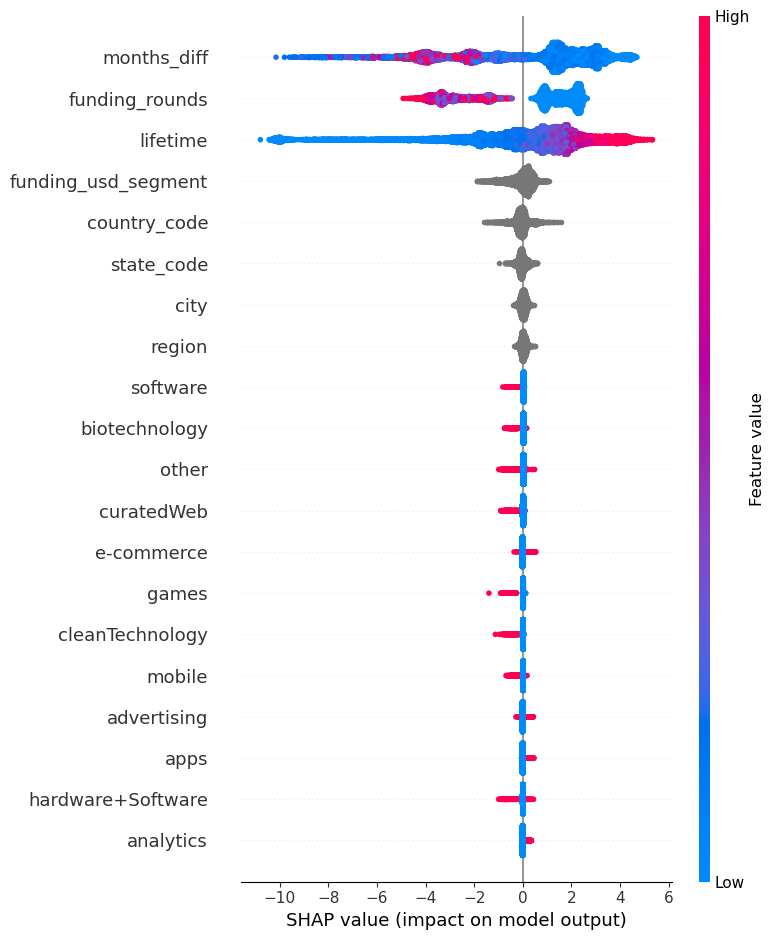

In [356]:

model_shap = model_cb1  # CatBoost
#model_shap = best_catboost_model  # CatBoost_grid 
#model_shap = y_pred_rfc_val  # RandomForestClassifier + RandomizedSearchCV
#model_shap = randomized_search  # RandomizedSearchCV

# Вычисляем SHAP-значения
explainer = shap.Explainer(model_shap) ## указываем интересующую нас модель
shap_values = explainer(X_validation)

# Визуализируем важность признаков
shap.summary_plot(shap_values, X_validation)


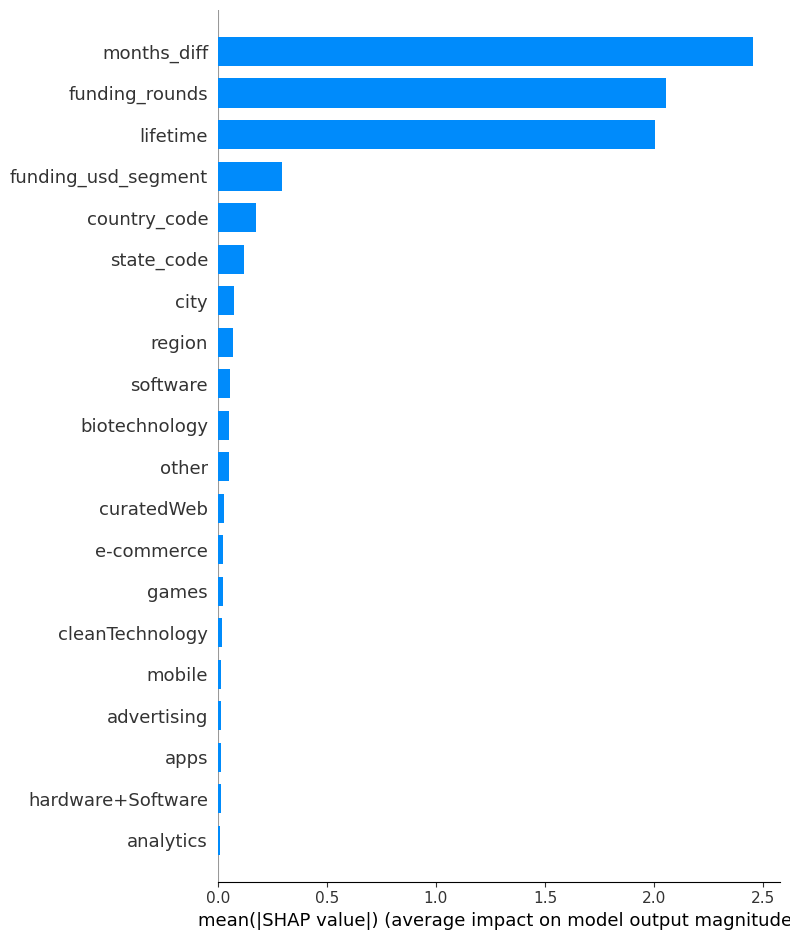

In [360]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

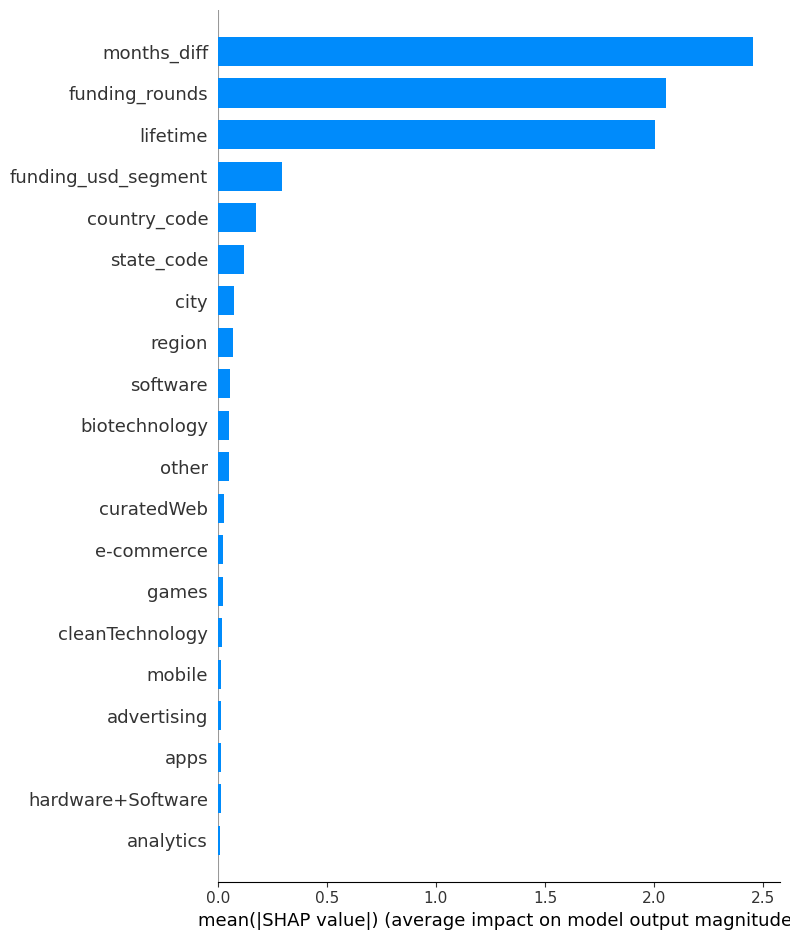

In [383]:
shap.summary_plot(shap_values, X_validation, plot_type='bar')

* Признак **months_diff** имеет наибольший вес.
* Признак **funding_rounds** второй по влиянию на результат.
* Так же заметны **lifetime**  Чем дольше компания существует - тем меньше шансов что она неожиданно закроется.
* Признак **funding_usd_segment** так же имеет заметное значение
* Замыкает 5ку весомых признаков  **country_code**


Посмотрим на несколько первых примеров. Оценим какие признаки максимально влияли на отнесение объектов к той или иной категории.

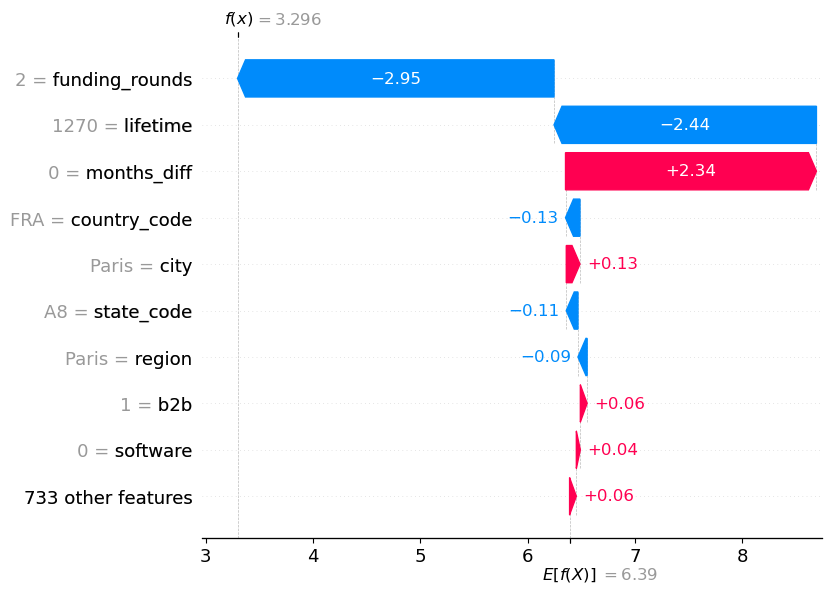

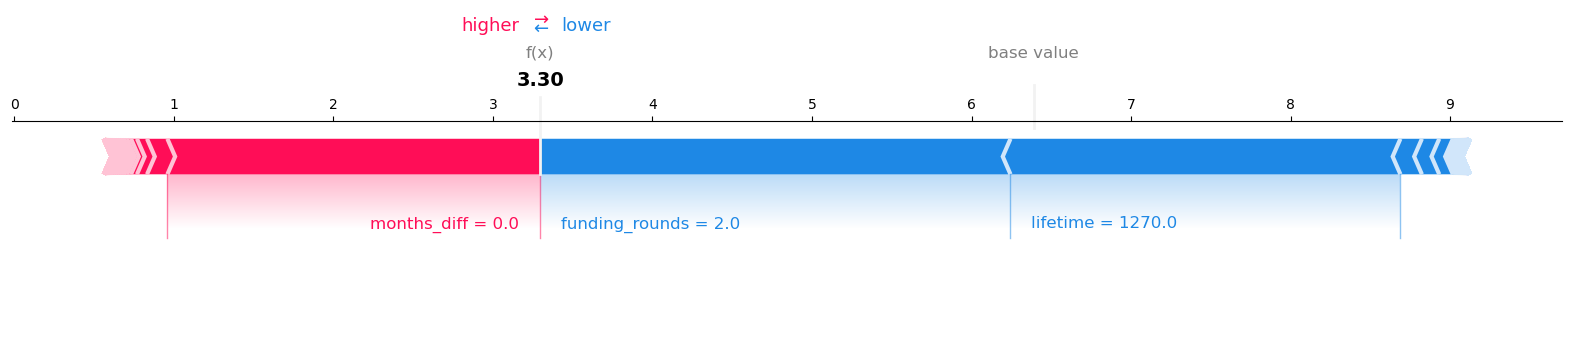

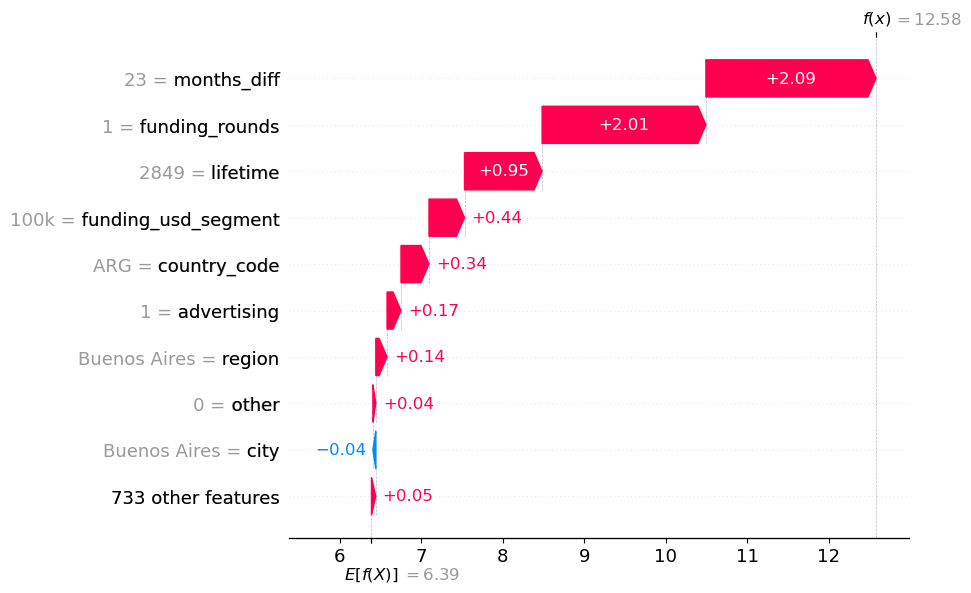

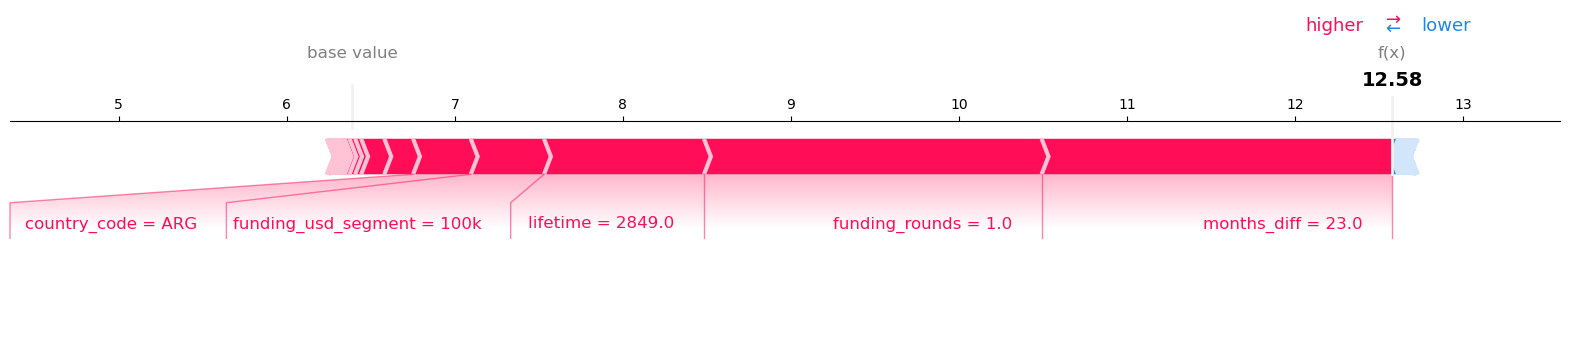

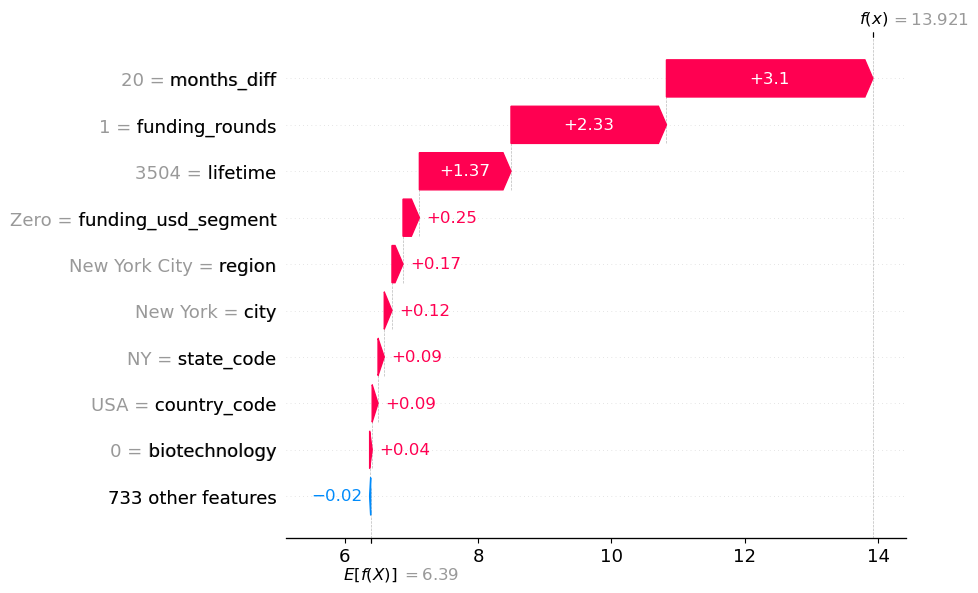

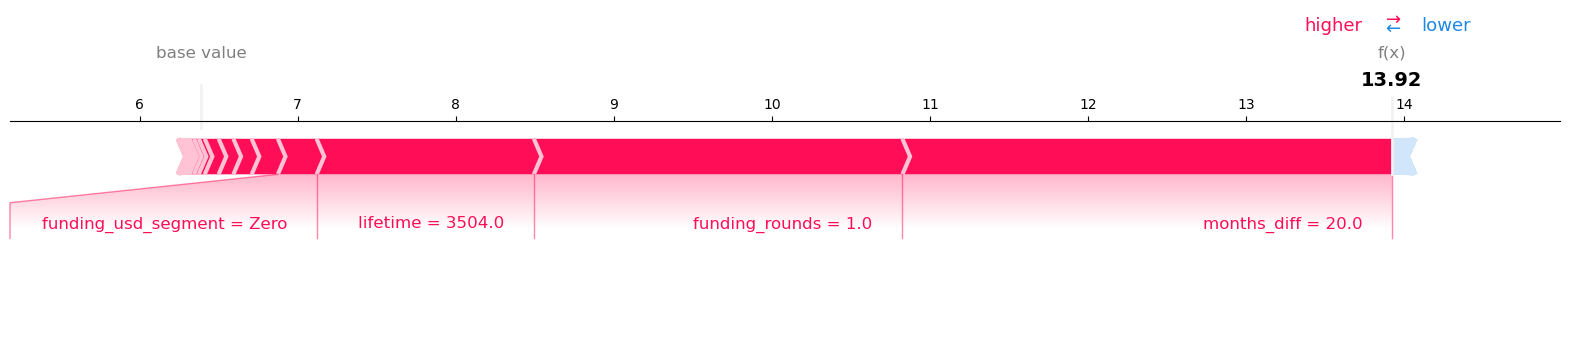

In [361]:
for i in range(3):
    shap.waterfall_plot(shap_values[i])
#    shap.force_plot(explainer.expected_value, shap_values.values[i], X_validation.iloc[i, :], matplotlib=True)

* Видно что funding_rounds = 1  повышает шансы стартапа на существование, а funding_rounds = 2 наоборот, снижает.
* Признак **months_diff** на данных примерах всегда прибавляет вероятности остатся действующей компанией. Возможно это лишний признак который сбивает качество обучения.
* Признак **lifetime** может как увеличить вероятность компании выжить, так и уменьшить его. Возможно это связано с тем что многие созданные в 2012-2014 годах  компании закрылись.
* Признак категории **funding_usd_segment** тоже на данном примере только увеличивает вероятность компании выжить. Даже если он равен "Zero" , т.е. когда компания не получила делен или об этом нет данных.

In [382]:
#shap.dependence_plot('months_diff', shap_values, X_test)

## Общий итог работы.

Были получены два набора данных: тренеровочный на 53к записей, и тестовый на 13к записей.
Оба набора были приведены к одинаковому набору признаков.
Добавлены синтетические признаки: 
* **months_diff** -количество месяцев между стартом компании и первым раундом финансирования.
* Созданы отдельные признаки содержащие год создания компании, год первого раунда финансирования, год последнего раунда финансирования.
* Созданы признаки с указанием какой категории принадлежит стартап.


Т.к. категрии стартапов заполняли люди очень произвольно, там большое количество мусора. Например чем занимается компания с категорией **indians**? 
Хорошим решением было бы привести все категории к фиксированному списку из 20-30-50 позиций.
Но перебирать вручную 800+ категорий, без понимания куда их относить, чем занимается компания... Это весьма непродуктивно. Большая часть сразу уйдёт в категорию *Other*. Когда в наборе данных 1/4 в одной категории, будет сложно разобраться. 
+ невозможность быстрой проверки результатов. На ттренеровочных данных F1-score достигал 0.98. Но проверке в Kaggle  цифры совсем другие. Значит или тестовые данные отличаются от тренеровочных, или явное переобучение.
+ Самые хорошие результате на тесте показал CatBoost. Т.к. он любит работать с категориями, нужно сделать больше категорий.
+ Я ещё не успел проверить следующие теории:

      перевести **lifetime** в категории. По кварталам, полугодиям, годам.
      перевести **months_diff** в категории. По кварталам, полугодиям, годам.
      ограничить компании по срокам жизни. Т.к. правила финансирования могут меняться, особенно после "пузыря ДотКомов", можно убрать все компании старше 20-25 лет.

+ Для более тонкой настройки расчёта CatBoost`ом нужно больше времене на большее количество итераций и больше количество перебираемых вариантов. Но с учётом того что расчёты на тренеровочных данных показывают хорошие результаты, а на тесте- не очень, это очень скользкий путь.
+ Как добится того чтобы расчёт на тренеровочных данных совпадал с тестом? Думаю что это главный вопрос который мы должны были решить. От него зависит перечень признаков.
+ На данный момент получен следующий списов значимых признаков
  
        Признак **months_diff** имеет наибольший вес.
        Признак **funding_rounds** второй по влиянию на результат.
        Так же заметны **lifetime**  Чем дольше компания существует - тем меньше шансов что она неожиданно закроется.
        Признак **funding_usd_segment** так же имеет заметное значение
        Замыкает 5ку весомых признаков  **country_code**

* Видно что funding_rounds = 1  повышает шансы стартапа на существование, а funding_rounds = 2 наоборот, снижает.
* Признак **months_diff** на данных примерах всегда прибавляет вероятности остатся действующей компанией. Возможно это лишний признак который сбивает качество обучения.
* Признак **lifetime** может как увеличить вероятность компании выжить, так и уменьшить его. Возможно это связано с тем что многие созданные в 2012-2014 годах  компании закрылись.
* Признак категории **funding_usd_segment** тоже на данном примере только увеличивает вероятность компании выжить. Даже если он равен "Zero" , т.е. когда компания не получила делен или об этом нет данных.
* 
Пока не получается в полной мере понять когда указанные признаки увеличивают вероятность стартапу выжить, а когда уменьшают. Без этого тяжело дать рекомендации.

  


##  Выгрузим результат 

In [ ]:
## Выгрузим результат расчёта

display(label_encoder.classes_)

#y_pred_proba = model_cb1.predict_proba(X_test)

#y_pred_cb = model_cb1.predict(X_test)


y_pred_proba = y_pred_cb

y_pred_encoded = y_pred_cb #model.predict(X_test)

#display(y_pred_cb)
#-----------------------------------

if y_pred.ndim == 2:
    y_pred = np.squeeze(y_pred)

#------------------------------------

# Преобразуем предсказания обратно в оригинальные метки
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Создаем DataFrame с предсказаниями и индексами тестовой выборки
results = pd.DataFrame({
    'Name': X_test.index,  # Индексы из исходного набора данных
 #   'Actual': y_test,       # Фактические значения
    'Status': y_pred     # Предсказанные значения
})
# Сохраняем результат в файл
results.to_csv('predictions.csv', index=False)

print("Результаты сохранены в файл 'predictions.csv'")

#display(results.head(15))
#display(results.loc[results['Status'] != 'operating'])